https://www.analyticsvidhya.com/blog/2021/06/tuning-hyperparameters-of-an-artificial-neural-network-leveraging-keras-tuner/

https://towardsdatascience.com/hyperparameter-tuning-with-keras-tuner-283474fbfbe

https://medium.com/towards-data-science/your-features-are-important-it-doesnt-mean-they-are-good-ff468ae2e3d4

In [ ]:
#!pip install numpy==1.23.4
!pip install keras_tuner
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install sklearn

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2951 sha256=0a8f17efbd06c0998b05d546b710b2b1472a7548398723f4eafc119166294a50
  Stored in directory: /root/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import date

from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree
from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats
import pylab

import shap
import re

from sklearn.feature_selection import mutual_info_regression

import lightgbm as lg
import xgboost as xg

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from sklearn.metrics import confusion_matrix
import itertools

import keras_tuner as kt
from keras_tuner import RandomSearch, HyperModel, BayesianOptimization, Hyperband
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf


### Functions

In [ ]:
#################
### Pie chart ###
#################

def pie_chat(name):
    c_loc = df.sort_values(by = name)
    c_loc = c_loc.groupby([name]).size().to_frame('Count').sort_values(ascending=False).reset_index()
    c_loc['perc'] = c_loc['Count']/df.shape[0] * 100
    c_loc = c_loc.sort_values(by = 'perc', ascending = False)
    c_loc['cum_perc'] = c_loc['perc'].cumsum()
    c_loc = c_loc.reset_index(drop=True)

    my_circle = plt.Circle( (0,0), 0.7, color='white')

    plt.pie(c_loc.perc, labels=c_loc[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

In [ ]:
############################################
### Data sub populations from tree model ###
############################################

def get_rules(tree, feature_names, class_names, perc_thold = 80, sample_thold = 100):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    proba = []
    samples = []
    for path in paths:
        #print(path)
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"

        if (np.round(100.0*classes[l]/np.sum(classes),2) > perc_thold) & (path[-1][1] > sample_thold):
            rules += [rule]
            proba += [np.round(100.0*classes[l]/np.sum(classes),2)]

    return rules, proba

In [ ]:
#################################
### Variance inflation factor ###
#################################

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return(vif)

In [ ]:
##############################
### Min-Max transformation ###
##############################

def minmax_dset(dset,numeric_columns):

    dseta = dset.copy()
    dsetb = pd.DataFrame(transformer_train.transform(dseta[numeric_columns]))
    dsetb.columns = numeric_columns
    print(dsetb.shape)
    return dsetb

In [ ]:
########################
### One hot encoding ###
########################

def ohe_dset(dset,categorical_columns):

    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

In [ ]:
class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(
            Dense(
                units=hp.Int('units', 8, 64, 4, default=8),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=input_shape
            )
        )

        model.add(
            Dense(
                units=hp.Int('units', 16, 64, 4, default=16),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
            )
        )

        model.add(
            Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.1,
                    default=0.005,
                    step=0.01)
            )
        )

        model.add(Dense(1))

        model.compile(
            optimizer='rmsprop',loss='mse',metrics=['mse']
        )

        return model

In [ ]:
def diag_vals(model):

  y_pred = model.predict(X_test)

  mae = mean_absolute_error(y_test, y_pred)
  print("MAE: ", mae)

  rmse = mean_squared_error(y_test, y_pred, squared=False)
  print("RMSE: ", rmse)

  r2 = r2_score(y_test, y_pred)
  print("R2 score: ", r2)

  return mae, rmse, r2

In [ ]:
def resid_vals(pred):

    y_pred = pd.DataFrame(pred, columns = ['Pred'])

    residual = y_test - y_pred.Pred.values

    y_pred.index = range(0,len(y_pred))
    residual.index = range(0,len(residual))
    a = pd.concat([residual,y_pred],axis=1,ignore_index=True)
    resid_data = pd.DataFrame(a)
    resid_data.columns = ['Residuals','Predicted']
    plt.plot(resid_data['Residuals'], 'o', color='blue', markersize=3)
    plt.title('Residual plot for model')
    plt.ylabel('Residuals')
    plt.show();

    ax = sns.jointplot(x=resid_data['Predicted'], y=resid_data['Residuals'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
    ax.ax_joint.set_xlabel('Predicted', fontweight='bold')
    ax.ax_joint.set_ylabel('Residuals', fontweight='bold')
    plt.show();

    stats.probplot(resid_data['Residuals'], dist="norm", plot=pylab)
    pylab.show();

### Read in the data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Change directory
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Diamond pricing")
# Print out the current directory
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Diamond pricing


In [ ]:
df1 = pd.read_csv('Diamonds Prices2022.csv', sep = ',')
df1 = df1.drop_duplicates()
df1 = df1.drop(['Unnamed: 0'], axis = 1)
print(df1.shape)
df1.head()

(53943, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


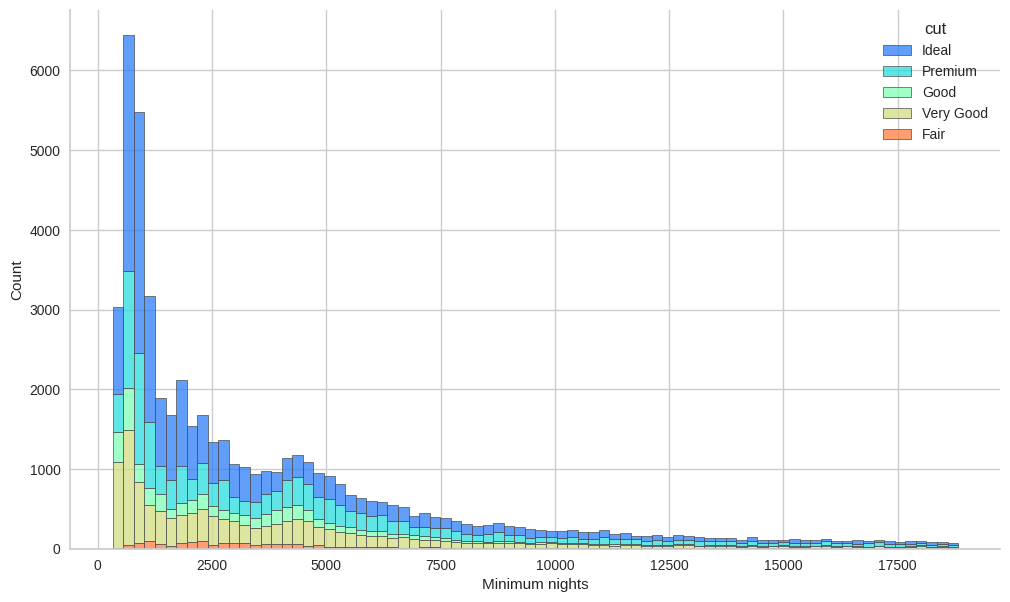

In [ ]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    df1,
    x="price", hue="cut",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Minimum nights")
plt.show();

### Adjust data

In [ ]:
#pd.crosstab(df.time_since.isnull(), columns = 'Count')

In [ ]:
#a = pd.crosstab(time_s, columns = 'Count')
#a = a.reset_index()
#a = a.sort_values(['Count'], ascending = False)
#a.head()
#a = pd.DataFrame(delat)
#a.median()[0]

In [ ]:
df = df1.copy()
df = df[(df.x > 0) & (df.y > 0) & (df.z > 0) & (df.y < 30) & (df.z < 30)]
df['xy_ratio'] = df.x / df.y
df['xz_ratio'] = df.x / df.z
df['yz_ratio'] = df.y / df.z
df['size'] = df.x * df.y * df.z

In [ ]:
#pd.crosstab(df.gender,columns = 'Count')
print(list(df.columns))

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'size']


In [ ]:
for i in range(df.shape[1]):
    print(f"The number of unique classes for {df.columns[i]} is {df.iloc[:,i].nunique()}")
    if df.iloc[:,i].nunique() < 15:
        print(f"    The classes are {df.iloc[:,i].unique()}")

The number of unique classes for carat is 273
The number of unique classes for cut is 5
    The classes are ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
The number of unique classes for color is 7
    The classes are ['E' 'I' 'J' 'H' 'F' 'G' 'D']
The number of unique classes for clarity is 8
    The classes are ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']
The number of unique classes for depth is 184
The number of unique classes for table is 127
The number of unique classes for price is 11597
The number of unique classes for x is 553
The number of unique classes for y is 548
The number of unique classes for z is 372
The number of unique classes for xy_ratio is 7578
The number of unique classes for xz_ratio is 11701
The number of unique classes for yz_ratio is 11856
The number of unique classes for size is 28462


In [ ]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,xy_ratio,xz_ratio,yz_ratio,size
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,0.992462,1.625514,1.637860,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,1.013021,1.683983,1.662338,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,0.995086,1.753247,1.761905,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,0.992908,1.596958,1.608365,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,0.997701,1.578182,1.581818,51.917250


### Missing data

In [ ]:
a = pd.DataFrame(df.isna().mean().round(4) * 100, columns = ['Count'])
a

,Count
carat,0.0
cut,0.0
color,0.0
clarity,0.0
depth,0.0
table,0.0
price,0.0
x,0.0
y,0.0
z,0.0


### Target variable

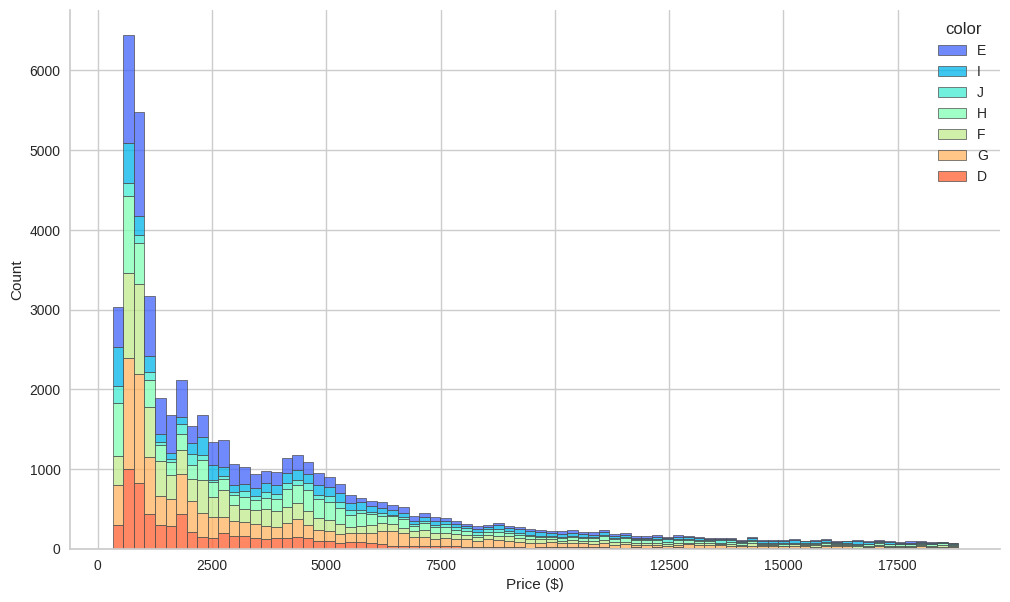

In [ ]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    df,
    x="price", hue="color",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Price ($)")
plt.show();

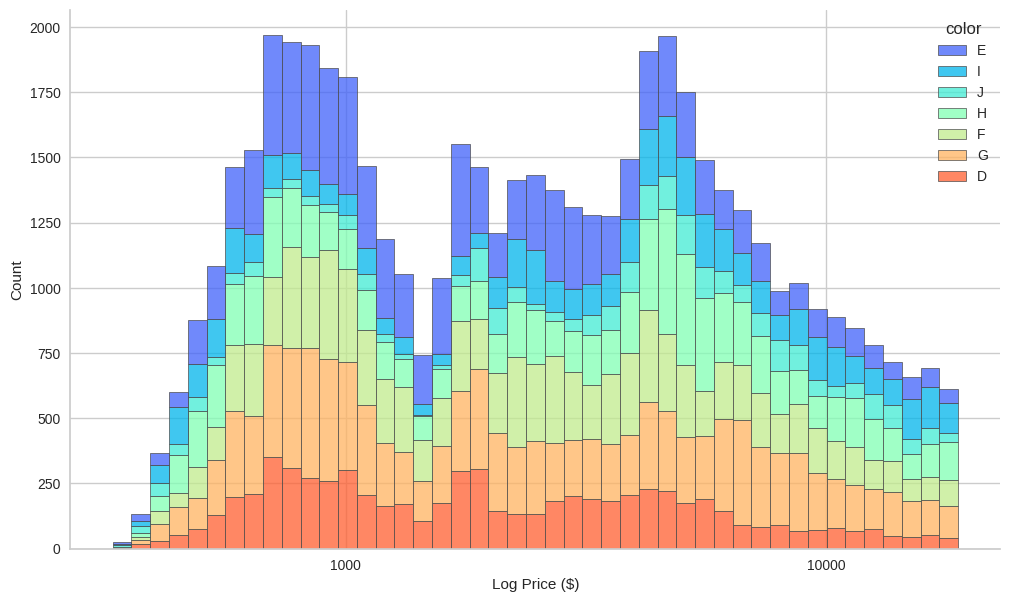

In [ ]:
dfa = df.copy()
dfa.price = dfa.price + 1

f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    dfa,
    x="price", hue="color",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Log Price ($)")
plt.show();

### Graphs

#### Pie charts

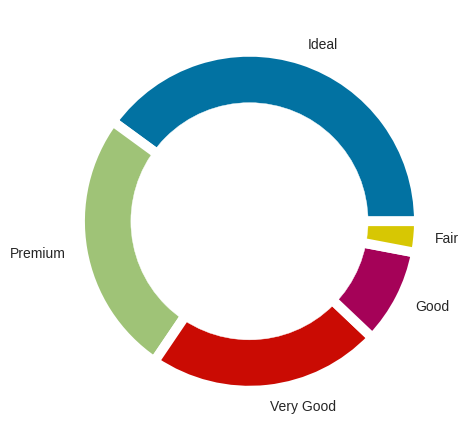

In [ ]:
pie_chat('cut')

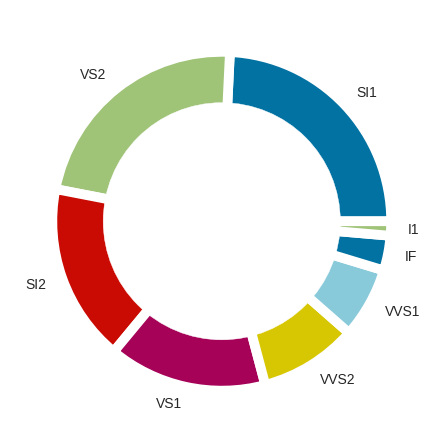

In [ ]:
pie_chat('clarity')

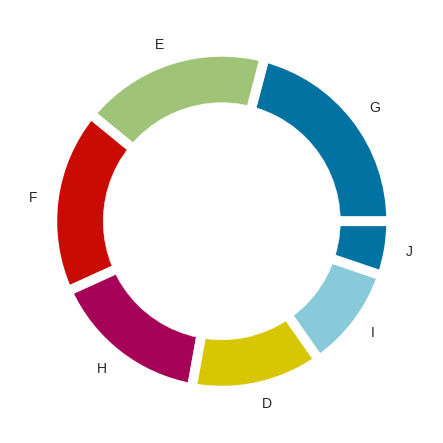

In [ ]:
pie_chat('color')

#### Scatter plots

In [ ]:
print(list(df.columns))

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'size']


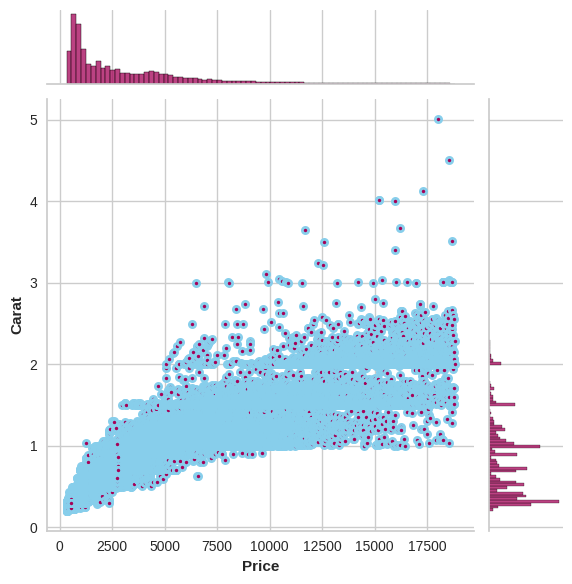

In [ ]:
ax = sns.jointplot(x=df['price'], y=df['carat'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('Price', fontweight='bold')
ax.ax_joint.set_ylabel('Carat', fontweight='bold')
plt.show();

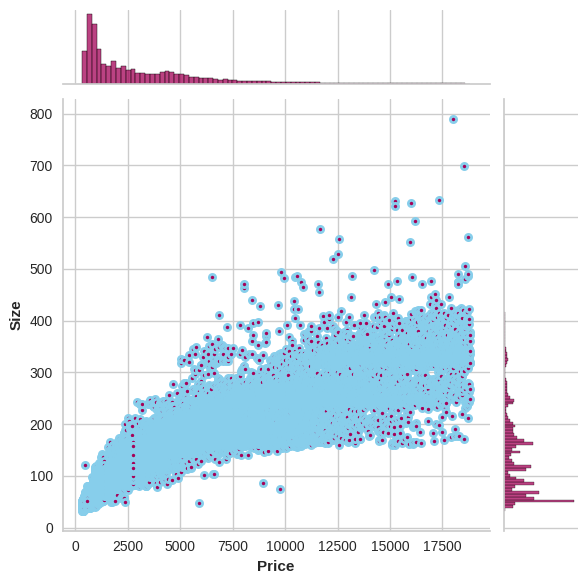

In [ ]:
ax = sns.jointplot(x=df['price'], y=df['size'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('Price', fontweight='bold')
ax.ax_joint.set_ylabel('Size', fontweight='bold')
plt.show();

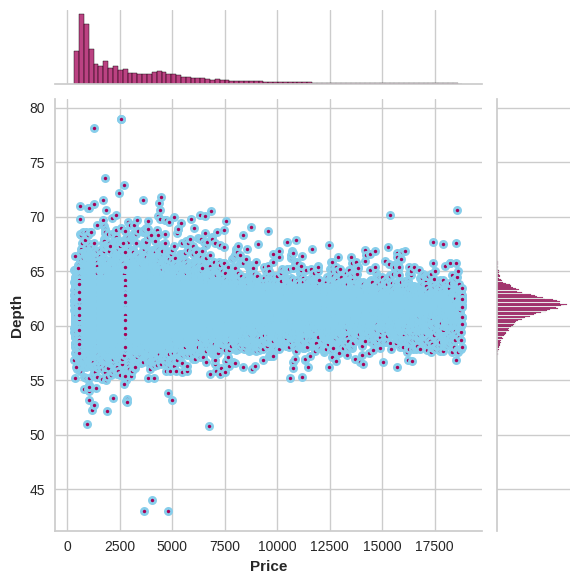

In [ ]:
ax = sns.jointplot(x=df['price'], y=df['depth'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('Price', fontweight='bold')
ax.ax_joint.set_ylabel('Depth', fontweight='bold')
plt.show();

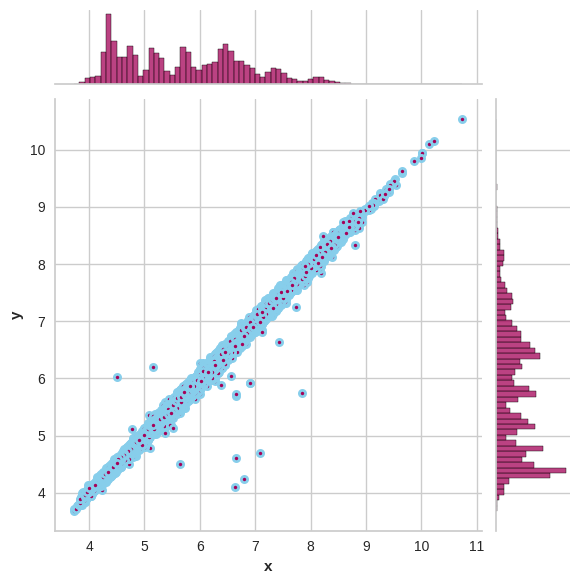

In [ ]:
ax = sns.jointplot(x=df['x'], y=df['y'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('x', fontweight='bold')
ax.ax_joint.set_ylabel('y', fontweight='bold')
plt.show();

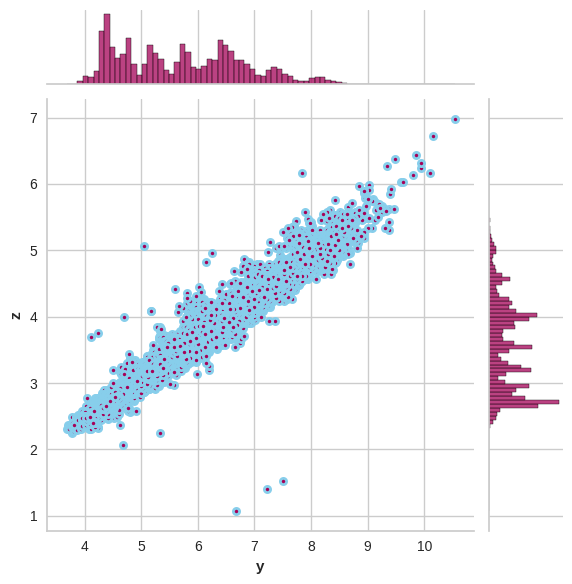

In [ ]:
ax = sns.jointplot(x=df['y'], y=df['z'], kind='scatter', s=20, color='m', edgecolor="skyblue", linewidth=2)
ax.ax_joint.set_xlabel('y', fontweight='bold')
ax.ax_joint.set_ylabel('z', fontweight='bold')
plt.show();

#### Box plots

In [ ]:
print(list(df.columns))

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'size']


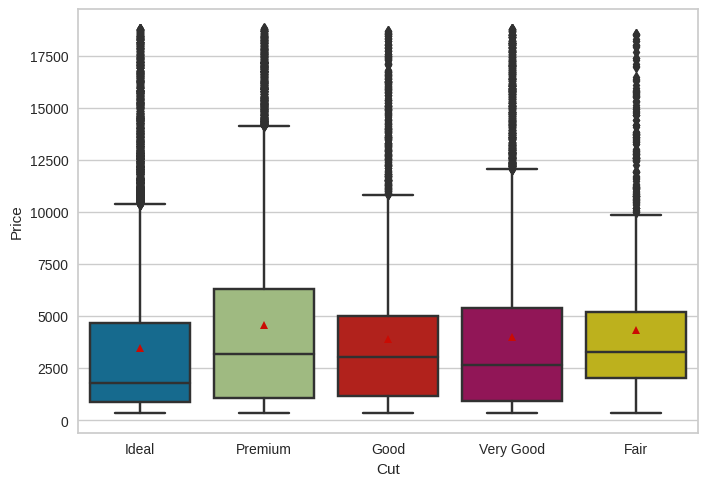

In [ ]:
sns.boxplot(data=df, x="cut", y="price", showmeans = True)
plt.xlabel("Cut")
plt.xticks(rotation=0)
plt.ylabel("Price")
plt.show()

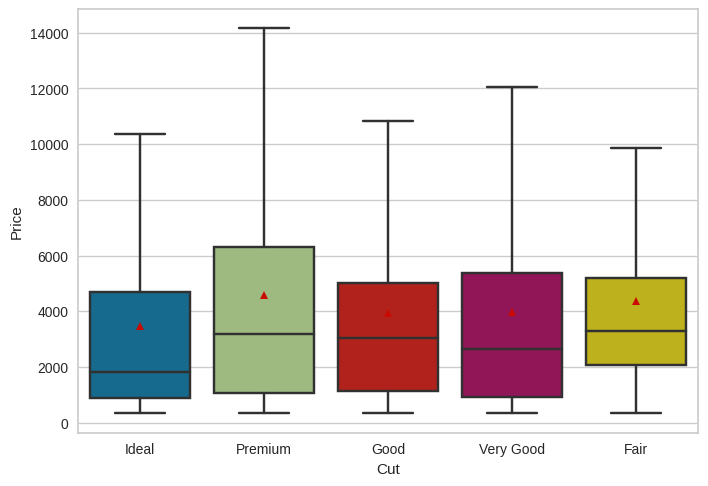

In [ ]:
sns.boxplot(data=df, x="cut", y="price", showfliers = False, showmeans = True)
plt.xlabel("Cut")
plt.xticks(rotation=0)
plt.ylabel("Price")
plt.show()

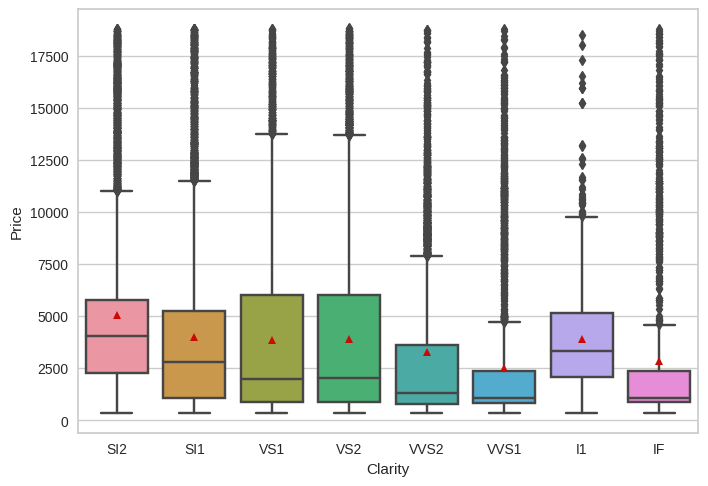

In [ ]:
sns.boxplot(data=df, x="clarity", y="price", showfliers = True, showmeans = True)
plt.xlabel("Clarity")
plt.xticks(rotation=0)
plt.ylabel("Price")
plt.show()

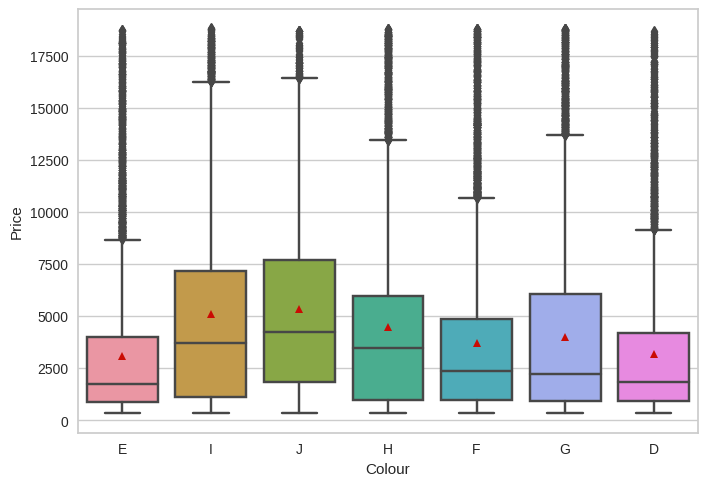

In [ ]:
sns.boxplot(data=df, x="color", y="price", showmeans = True)
plt.xlabel("Colour")
plt.xticks(rotation=0)
plt.ylabel("Price")
plt.show()

#### Rel plots

In [ ]:
# room_type_Entire_homeapt            0.290289
# room_type_Private_room              0.249939
# calculated_host_listings_count      0.157652
# neighbourhood_group_Manhattan       0.074881
# minimum_nights                      0.049430
# availability_365                    0.035308
# neighbourhood_group_Brooklyn        0.028105
# time_since                          0.028033

In [ ]:
print(list(df.columns))

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'size']


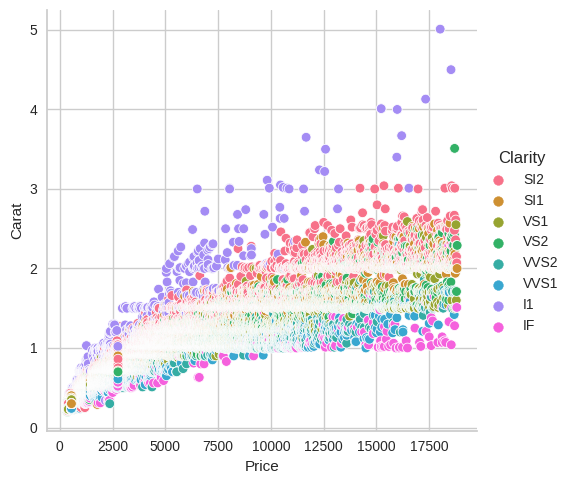

In [ ]:
relplot = sns.relplot(x='price',
            y='carat',
            data=df,
            kind='scatter',
            hue='clarity');
relplot.set_ylabels("Carat", clear_inner=False)
relplot.set_xlabels("Price", clear_inner=False)
relplot._legend.set_title("Clarity")
plt.show();

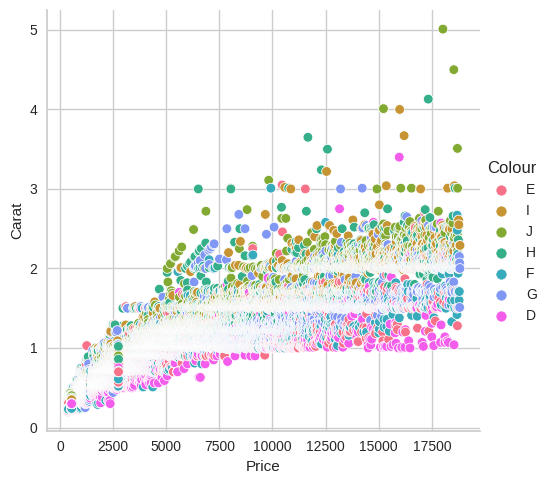

In [ ]:
relplot = sns.relplot(x='price',
            y='carat',
            data=df,
            kind='scatter',
            hue='color');
relplot.set_ylabels("Carat", clear_inner=False)
relplot.set_xlabels("Price", clear_inner=False)
relplot._legend.set_title("Colour")
plt.show();

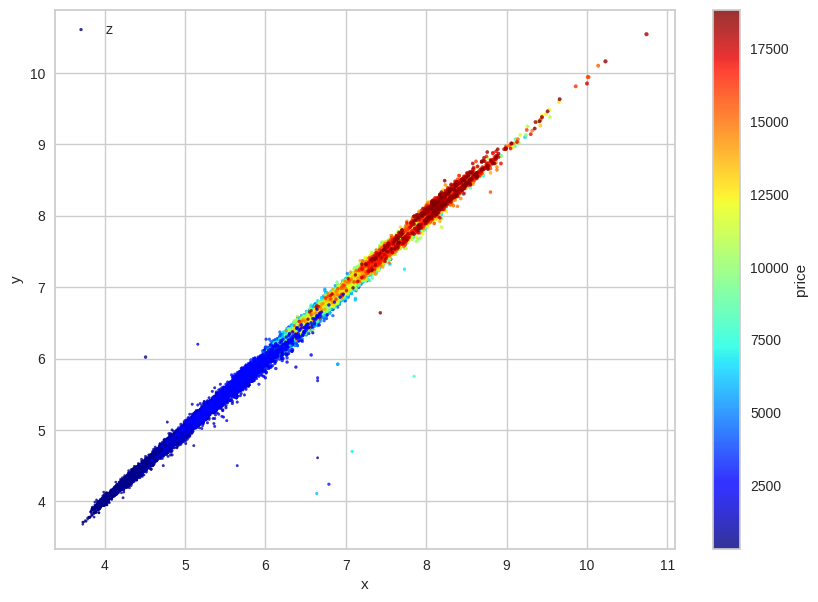

In [ ]:
dfa = df[(df.y < 30) & (df.x > 3) & (df.y > 3)]
dfa.plot(kind="scatter", x="x", y="y", alpha=0.8,
             s=dfa["z"], label="z", figsize=(10,7),
             c="price", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show()

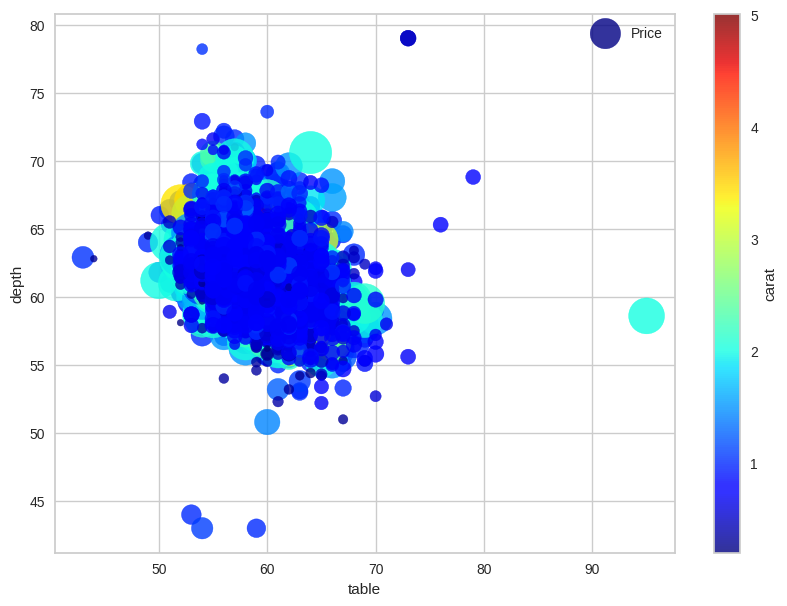

In [ ]:
dfa = df.copy()
dfa.price = dfa.price / 20
dfa.plot(kind="scatter", x="table", y="depth", alpha=0.8,
             s=dfa["price"], label="Price", figsize=(10,7),
             c="carat", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show();

#### Heat maps

In [ ]:
print(list(df.columns))

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'size']


In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


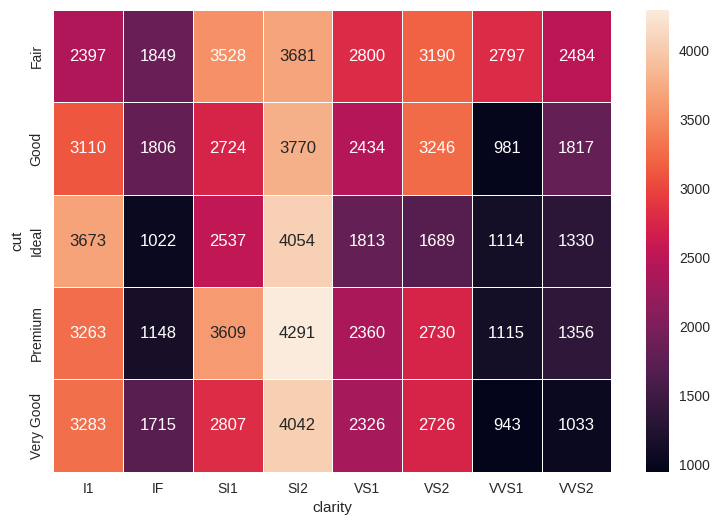

In [ ]:
data_a = df.groupby(['cut','clarity'])['price'].median().reset_index()
data_a = data_a.pivot("cut","clarity", "price")
data_a.head()

for i in range(data_a.shape[1]):
    data_a.iloc[:,i] = data_a.iloc[:,i].fillna(0)
    data_a.iloc[:,i] = data_a.iloc[:,i].astype(int)

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_a, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.show();

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


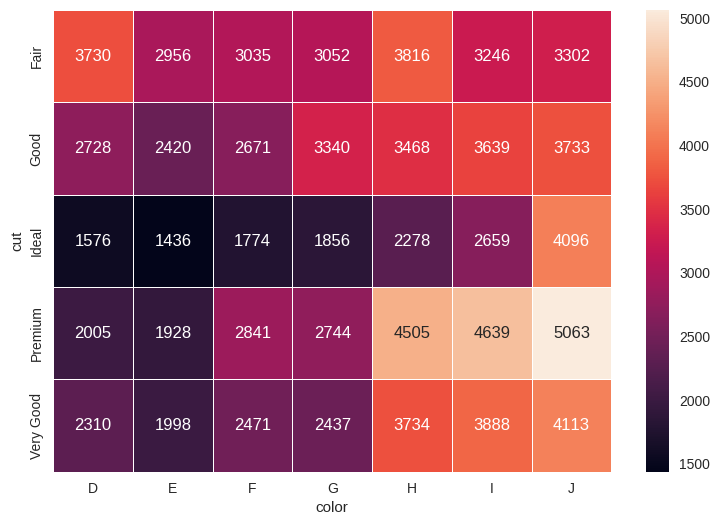

In [ ]:
data_a = df.groupby(['cut','color'])['price'].median().reset_index()
data_a = data_a.pivot("cut","color", "price")
data_a.head()

for i in range(data_a.shape[1]):
    data_a.iloc[:,i] = data_a.iloc[:,i].fillna(0)
    data_a.iloc[:,i] = data_a.iloc[:,i].astype(int)

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_a, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.show();

#### Compare plot

In [ ]:
data_b = df.groupby(['clarity','color'])['price'].median().sort_values("clarity", ascending=True).reset_index()
data_c = data_b
data_c = data_c.pivot('clarity','color', "price")
data_c = data_c.reset_index()
#data_c = data_c.sort_values("clarity", ascending=True)

for name in ['D','E','F','G','H','I','J']:
    data_c.loc[:,name] = data_c.loc[:,name].fillna(0)
    data_c.loc[:,name] = data_c.loc[:,name].astype(int)
data_c.head()

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


color,clarity,D,E,F,G,H,I,J
0,I1,3774,3296,2856,2999,3669,3054,4546
1,IF,4632,1208,1046,1052,1074,895,1061
2,SI1,1759,2258,2659,2604,4561,4368,4275
3,SI2,3468,3612,3812,4032,4540,5170,4656
4,VS1,1860,1665,2036,1890,2175,2847,3557


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


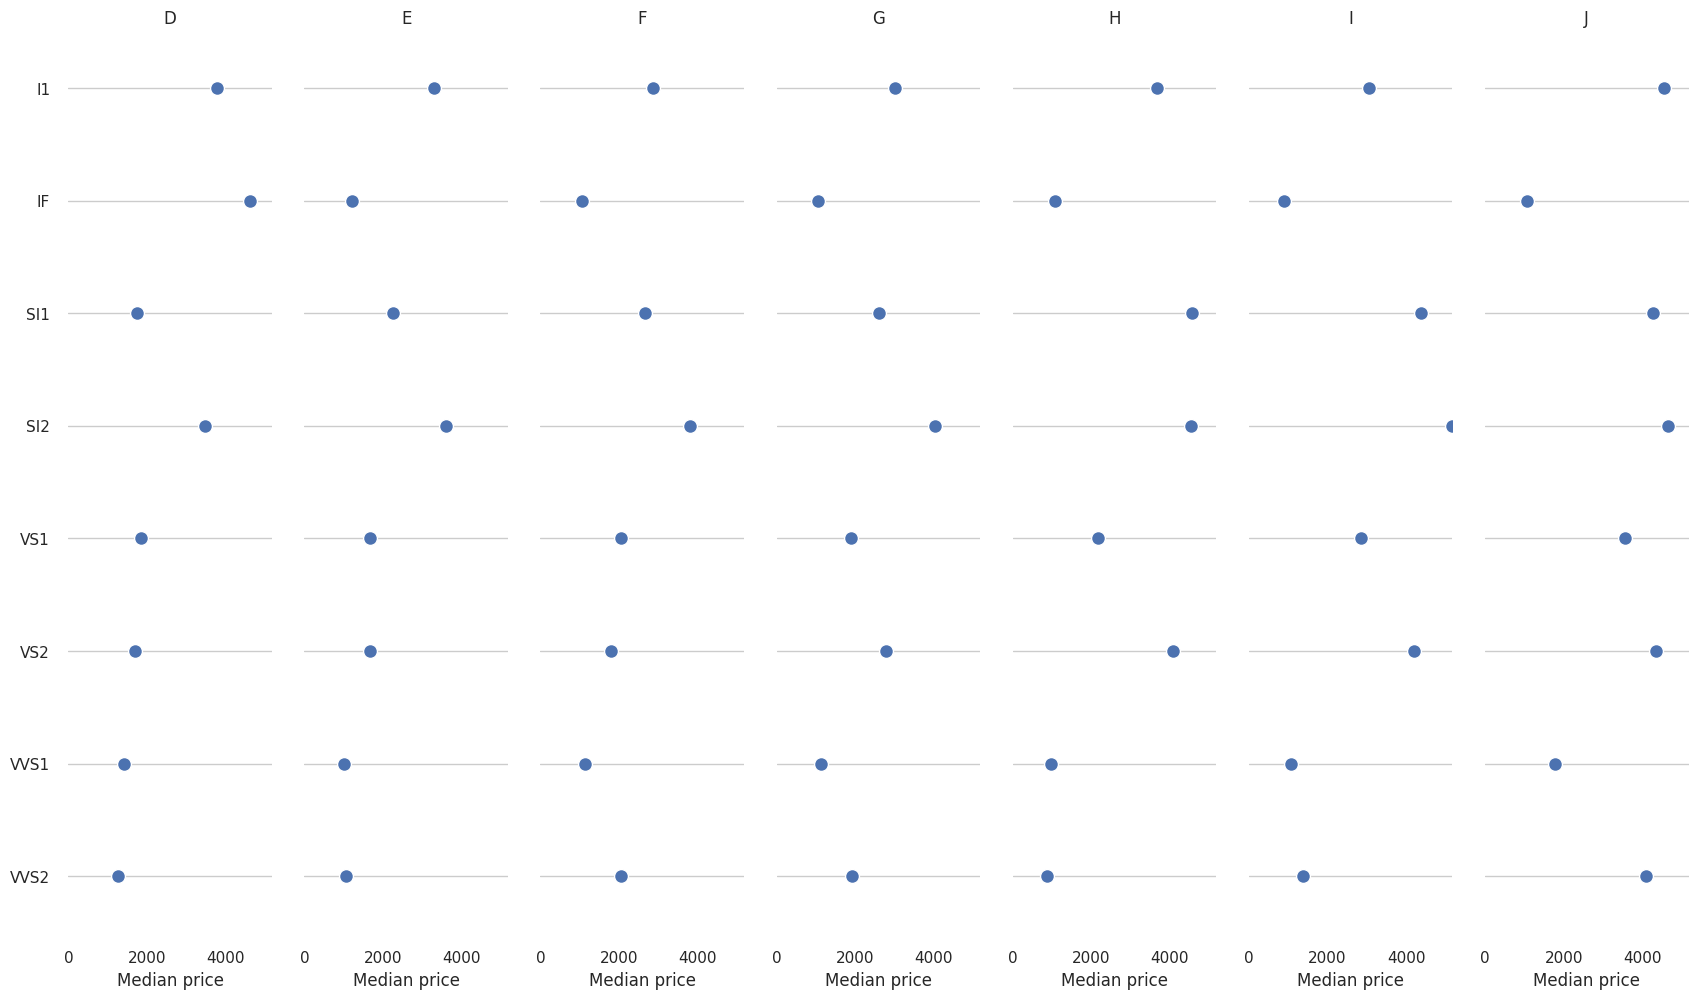

In [ ]:
sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(data_c,
                 x_vars=data_c.columns[1:], y_vars=["clarity"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-5, max(data_c.max(axis = 1)) + 10), xlabel="Median price", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['D','E','F','G','H','I','J']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

### New features

In [ ]:
for name in ['feature_1','feature_2','feature_3','feature_4']:
    df[name] = 0

df.loc[((df['x'] >= 6.41) & (df['x'] < 6.68) & (df['z'] >= 2.69)),'feature_1'] = 1
df.loc[(df['x'] >= 6.41) & (df['x'] < 6.68) & ((df['y'] < 4.54) | (df['y'] >= 4.82)),'feature_2'] = 1
df.loc[(df['y'] < 6.07) & ((df['x'] < 5.22) | (df['x'] >= 5.68)),'feature_3'] = 1
df.loc[(df['x'] >= 6.41) & (df['x'] < 6.68) & (df['z'] >= 2.69),'feature_4'] = 1

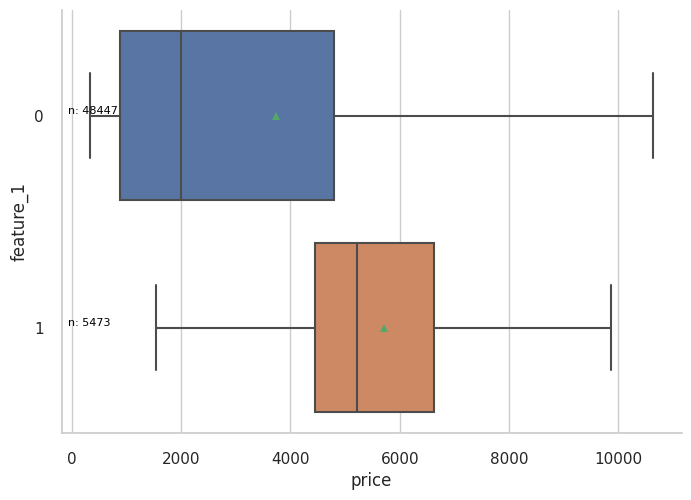

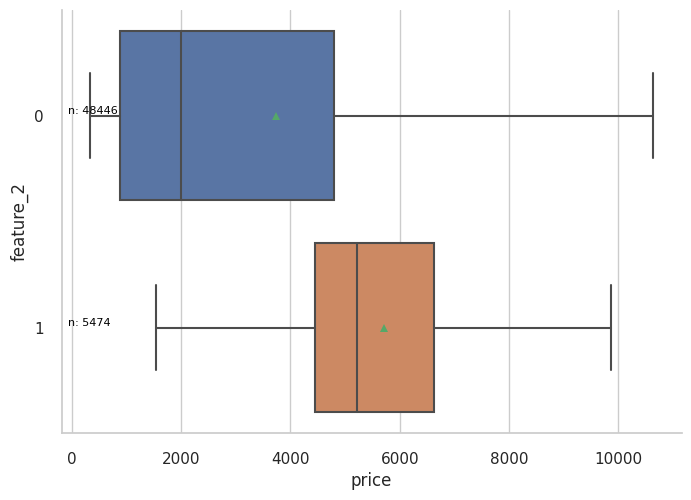

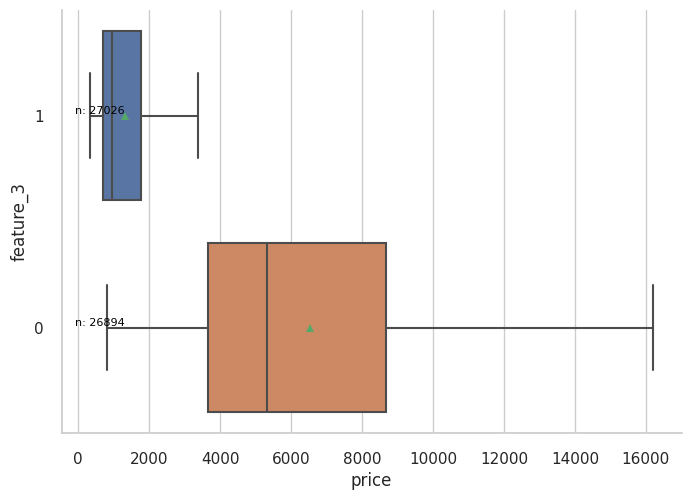

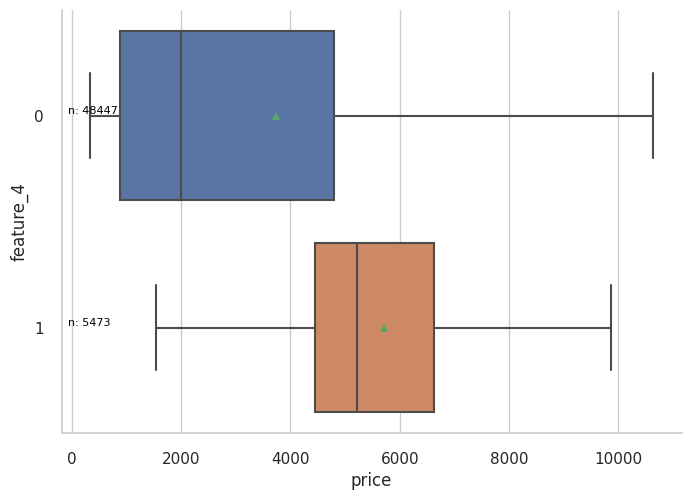

In [ ]:
for name in [col for col in df.columns if 'feature_' in col]:

    dfa = df.copy()
    dfa[name] = dfa[name].astype(str)

    ax = sns.boxplot(x="price", y=name, data=dfa, showfliers = False, showmeans = True)
    medians = dfa.groupby([name])['price'].median().values
    medians = np.array([-80, -80])
    nobs = dfa[name].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_yticklabels()):
        ax.text(medians[tick],tick,nobs[tick],color='black', verticalalignment = "bottom", size=8, fontdict=None)
    sns.despine()
    plt.show();

### Prediction

In [ ]:
mod_data = df.copy()

In [ ]:
a = pd.DataFrame(mod_data.isna().mean().round(4) * 100, columns = ['Count'])
a[a.Count > 0]

,Count


In [ ]:
y = mod_data.price
X = mod_data.drop(['price','carat','feature_3'], axis = 1)
X.head()

,cut,color,clarity,depth,table,x,y,z,xy_ratio,xz_ratio,yz_ratio,size,feature_1,feature_2,feature_4
0,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,0.992462,1.625514,1.637860,38.202030,0,0,0
1,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,1.013021,1.683983,1.662338,34.505856,0,0,0
2,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,0.995086,1.753247,1.761905,38.076885,0,0,0
3,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,0.992908,1.596958,1.608365,46.724580,0,0,0
4,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,0.997701,1.578182,1.581818,51.917250,0,0,0


#### Test-Train split

In [ ]:
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

for train_index, val_index in skf.split(X_train, y_train):
    print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

The least populated class in y has only 1 members, which is less than n_splits=5.


TRAIN: [    1     2     3 ... 53917 53918 53919] TEST: [    0     5    10 ... 53881 53900 53901]
TRAIN: [    0     2     3 ... 53917 53918 53919] TEST: [    1     6    11 ... 53902 53903 53909]
TRAIN: [    0     1     3 ... 53917 53918 53919] TEST: [    2     7    12 ... 53910 53911 53912]
TRAIN: [    0     1     2 ... 53917 53918 53919] TEST: [    3     8    13 ... 53913 53914 53915]
TRAIN: [    0     1     2 ... 53913 53914 53915] TEST: [    4     9    15 ... 53917 53918 53919]
(43136, 15) (10784, 15) (43136,) (10784,)


The least populated class in y has only 1 members, which is less than n_splits=5.


TRAIN: [    1     2     3 ... 43133 43134 43135] TEST: [    0     4    10 ... 43118 43121 43122]
TRAIN: [    0     2     3 ... 43133 43134 43135] TEST: [    1     6    11 ... 43119 43123 43129]
TRAIN: [    0     1     3 ... 43133 43134 43135] TEST: [    2     7    12 ... 43124 43130 43131]
TRAIN: [    0     1     2 ... 43131 43134 43135] TEST: [    3     8    13 ... 43126 43132 43133]
TRAIN: [    0     1     2 ... 43131 43132 43133] TEST: [    5     9    16 ... 43128 43134 43135]
(34509, 15) (8627, 15) (34509,) (8627,)


#### Infilling

In [ ]:
#check = X_train.groupby("neighbourhood_group")["reviews_per_month"].mean()
#X_train["reviews_per_month"] = X_train.groupby("neighbourhood_group")["reviews_per_month"].transform(lambda x: x.fillna(x.mean()))
#X_test["reviews_per_month"] = X_train.groupby("neighbourhood_group")["reviews_per_month"].transform(lambda x: x.fillna(x.mean()))
#check

In [ ]:
#a = pd.DataFrame(X_train.isna().mean().round(4) * 100, columns = ['Count'])
#a[a.Count > 0]

#### New features (not needed to rerun)

In [ ]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))
num_cols = num_cols + ['price']
num_cols.remove('carat')

X_train_b = pd.concat([X_train,y_train], axis = 1)

for m_val in num_cols:
    X_train_b[m_val + '_bin'], bin_edges  = pd.qcut(X_train_b[m_val],
                                                   q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                   retbins = True,
                                                   duplicates = 'drop')
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train_b[m_val + '_bin']  = pd.cut(X_train_b[m_val],
                                       bins = bin_edges,
                                       labels = range(len(bin_edges)-1),
                                       duplicates = 'drop',
                                       include_lowest=True)
    X_train_b[m_val + '_bin']  = X_train_b[m_val + '_bin'].astype(str)
    X_train_b.loc[X_train_b[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

In [ ]:
cat_cols = X_train.select_dtypes(include=np.object).columns.tolist()
print(cat_cols)

In [ ]:
bin_m_data = [col for col in X_train_b.columns if '_bin' in col and '_miss_' not in col]
print(bin_m_data)
X_train_b[bin_m_data + cat_cols].head()

In [ ]:
pd.crosstab(X_train_b.price_bin, columns = 'Count')
X_train_b.loc[(X_train_b.price_bin.isin(['0','1'])),'price_class'] = 0
X_train_b.loc[(X_train_b.price_bin.isin(['8','9'])),'price_class'] = 1
pd.crosstab(X_train_b.price_class, columns = 'Count')

In [ ]:
bin_m_data.remove('price_bin')
#cat_cols.remove('Country')
a = bin_m_data + cat_cols
a.sort()
print(a)

In [ ]:
print(X_train_b.shape)
X_train_b = X_train_b[~X_train_b.price_class.isna()]
print(X_train_b.shape)
y = X_train_b.price_class
X = X_train_b[bin_m_data + cat_cols]

In [ ]:
ohe = OneHotEncoder()

ohe.fit(X)
colnames = ohe.get_feature_names_out(list(X.columns))

bin_data_train = ohe_dset(X,list(X.columns))
print(bin_data_train.shape)

In [ ]:
print(list(bin_data_train.columns))

In [ ]:
clf = DecisionTreeClassifier(max_depth=5, random_state=1234)
model = clf.fit(bin_data_train, y)

text_representation = tree.export_text(clf, feature_names=list(bin_data_train.columns))

In [ ]:
rule_lst = []
flattened_lst = []
flattened_lsts = []

for split_size in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    X_trees, X_tree_test, y_trees, y_tree_test = train_test_split(bin_data_train,
                                                                  y,
                                                                  test_size = split_size,
                                                                  stratify = y,
                                                                  random_state = 222)
    print(X_trees.shape, y_trees.shape)

    model = clf.fit(X_trees, y_trees)
    text_representation = tree.export_text(clf, feature_names=list(X_trees.columns))
    rules, proba = get_rules(clf, list(X_trees.columns), [0,1], 60, 100)
    rule_lst.append(list(set(rules)))
    flattened_lst = [val for sublist in rule_lst for val in sublist]
    flattened_lst = list(set(flattened_lst))

for i in range(len(flattened_lst)):
    flattened_lsts.append(flattened_lst[i].split(' then class')[0])
flattened_lsts = list(set(flattened_lsts))

In [ ]:
flattened_lsts

#### Binning data

In [ ]:
m_val_lst = ['x','y','z']

for m_val in m_val_lst:
    check = X_train[~X_train[m_val].isna()]
    check[m_val + '_bin'], bin_edges  = pd.qcut(check[m_val],
                                                   q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                   retbins = True,
                                                   duplicates = 'drop')
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train[m_val + '_bin']  = pd.cut(X_train[m_val],
                                       bins = bin_edges,
                                       labels = range(len(bin_edges)-1),
                                       duplicates = 'drop',
                                       include_lowest=True)
    X_train[m_val + '_bin']  = X_train[m_val + '_bin'].astype(str)
    X_train.loc[X_train[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

    ### Test data ###
    X_test[m_val + '_bin'] = pd.cut(X_test[m_val],
                                    bins = bin_edges,
                                    labels = range(len(bin_edges)-1),
                                    include_lowest=True)

    X_test[m_val + '_bin'] = X_test[m_val + '_bin'].astype('str')
    X_test.loc[X_test[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

    ### Validation data ###
    X_val[m_val + '_bin'] = pd.cut(X_val[m_val],
                                   bins = bin_edges,
                                   labels = range(len(bin_edges)-1),
                                   include_lowest=True)

    X_val[m_val + '_bin'] = X_val[m_val + '_bin'].astype('str')
    X_val.loc[X_val[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

X_train = X_train.drop(m_val_lst, axis = 1)
X_test = X_test.drop(m_val_lst, axis = 1)
X_val = X_val.drop(m_val_lst, axis = 1)

x [ 3.73  4.35  4.48  4.74  5.19  6.06  6.38  6.57  6.87  7.41 10.74] range(0, 10)
y [ 3.68   4.35   4.49   4.75   5.19   6.06   6.38   6.57   6.86   7.402
 10.54 ] range(0, 10)
z [1.07 2.69 2.77 2.93 3.21 3.75 3.95 4.05 4.23 4.58 6.98] range(0, 10)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
#pd.crosstab(X_train.reviews_per_month_bin, columns = 'Count')

#### Numeric data

In [ ]:
#pd.crosstab(X_train.gender,columns = 'Count')

In [ ]:
#pd.crosstab(X_test.gender,columns = 'Count')

In [ ]:
#########################################
### Check for single non varying data ###
#########################################

lst = []
for name in list(X_train.columns):
    if (X_train[name].nunique() == 1):
        lst.append(name)

print(lst)

[]


In [ ]:
try:
    X_train = X_train.drop(lst, axis=1)
    X_test = X_test.drop(lst, axis=1)
    X_val = X_val.drop(lst, axis=1)
except:
    X_train = X_train
    X_test = X_test
    X_val = X_val

In [ ]:
#########################
### Multicollinearity ###
#########################

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

vif = calculate_vif(X_train[num_cols])

a = vif[(vif.VIF > 10)]
to_drop_vif = list(a.Features)
print(to_drop_vif)
vif = vif.sort_values(['VIF'], ascending = False)
vif

['depth', 'table', 'xy_ratio', 'xz_ratio', 'yz_ratio', 'feature_1', 'feature_2', 'feature_4']


divide by zero encountered in double_scalars


,Features,VIF
6,feature_1,inf
8,feature_4,inf
3,xz_ratio,3.375921e+04
4,yz_ratio,2.023309e+04
2,xy_ratio,1.678498e+04
7,feature_2,7.558494e+03
0,depth,5.354993e+03
1,table,7.854894e+02
5,size,4.095545e+00


In [ ]:
try:
    X_train = X_train.drop(to_drop_vif, axis=1)
    X_test = X_test.drop(to_drop_vif, axis=1)
    X_val = X_val.drop(to_drop_vif, axis=1)
except:
    X_train = X_train
    X_test = X_test
    X_val = X_val

In [ ]:
import statsmodels.api as sm

O = y_train
# To estimate the effect the addition/removal of a feature C
# has on the relationship between an independent feature I and an outcome O

conf = []
for I in num_cols:
    # build a baseline model for the  effect of I on  O
    model = sm.OLS(O, sm.add_constant(X_train[I])).fit()
    IO_coef, IO_sig = model.params[I], model.pvalues[I]

    ## Access the effect of
    for C in num_cols:
        if C != I:
            # build an auxilliary model adding C to the relationship between I and O
            model2 = sm.OLS(O, sm.add_constant(X_train[[I, C]])).fit()
            ico_preds = model2.predict()
            ICO_coef, ICO_sig = model2.params[I], model2.pvalues[I]

            # build a baseline model for the effect of C on  O
            model3 = sm.OLS(O, sm.add_constant(X_train[C])).fit()
            CO_coef, CO_sig = model3.params[C], model3.pvalues[C]

            corr_IC, _ = stats.pearsonr(X_train[I], X_train[C]) # CORR The independent vs the control
            corr_IO, _ = stats.pearsonr(X_train[I], O) #CORR The independent vs the outcome
            corr_CO, _ = stats.pearsonr(X_train[C], O) #CORR The control vs the outcome
            conf.append({"I_C":f"{I}_{C}",
                                "IO_coef":IO_coef, "IO_sig":IO_sig,
                                "CO_coef":CO_coef, "CO_sig":CO_sig,
                                "ICO_sig":ICO_sig, "ICO_coef": ICO_coef,
                                "corr_IC":corr_IC,
                                "corr_IO":corr_IO,
                                "corr_CO":corr_CO})

cc = pd.DataFrame(conf)
corr_ic = (cc['corr_IC'] > 0.5) | (cc['corr_IC'] < -0.5) # I is correlated with C
corr_co = (cc['corr_CO'] > 0.5) | (cc['corr_CO'] < -0.5) # C is correlated with O
corr_io = (cc['corr_IO'] > 0.5) | (cc['corr_IO'] < -0.5) # C is correlated with O

## C and O are significantly correlated
co_sig = (cc['CO_sig'] < 0.01) # The C is independetly predictive of O
io_sig = (cc['IO_sig'] < 0.01)

cc[corr_ic & corr_io & corr_co & co_sig & io_sig]

,I_C,IO_coef,IO_sig,CO_coef,CO_sig,ICO_sig,ICO_coef,corr_IC,corr_IO,corr_CO


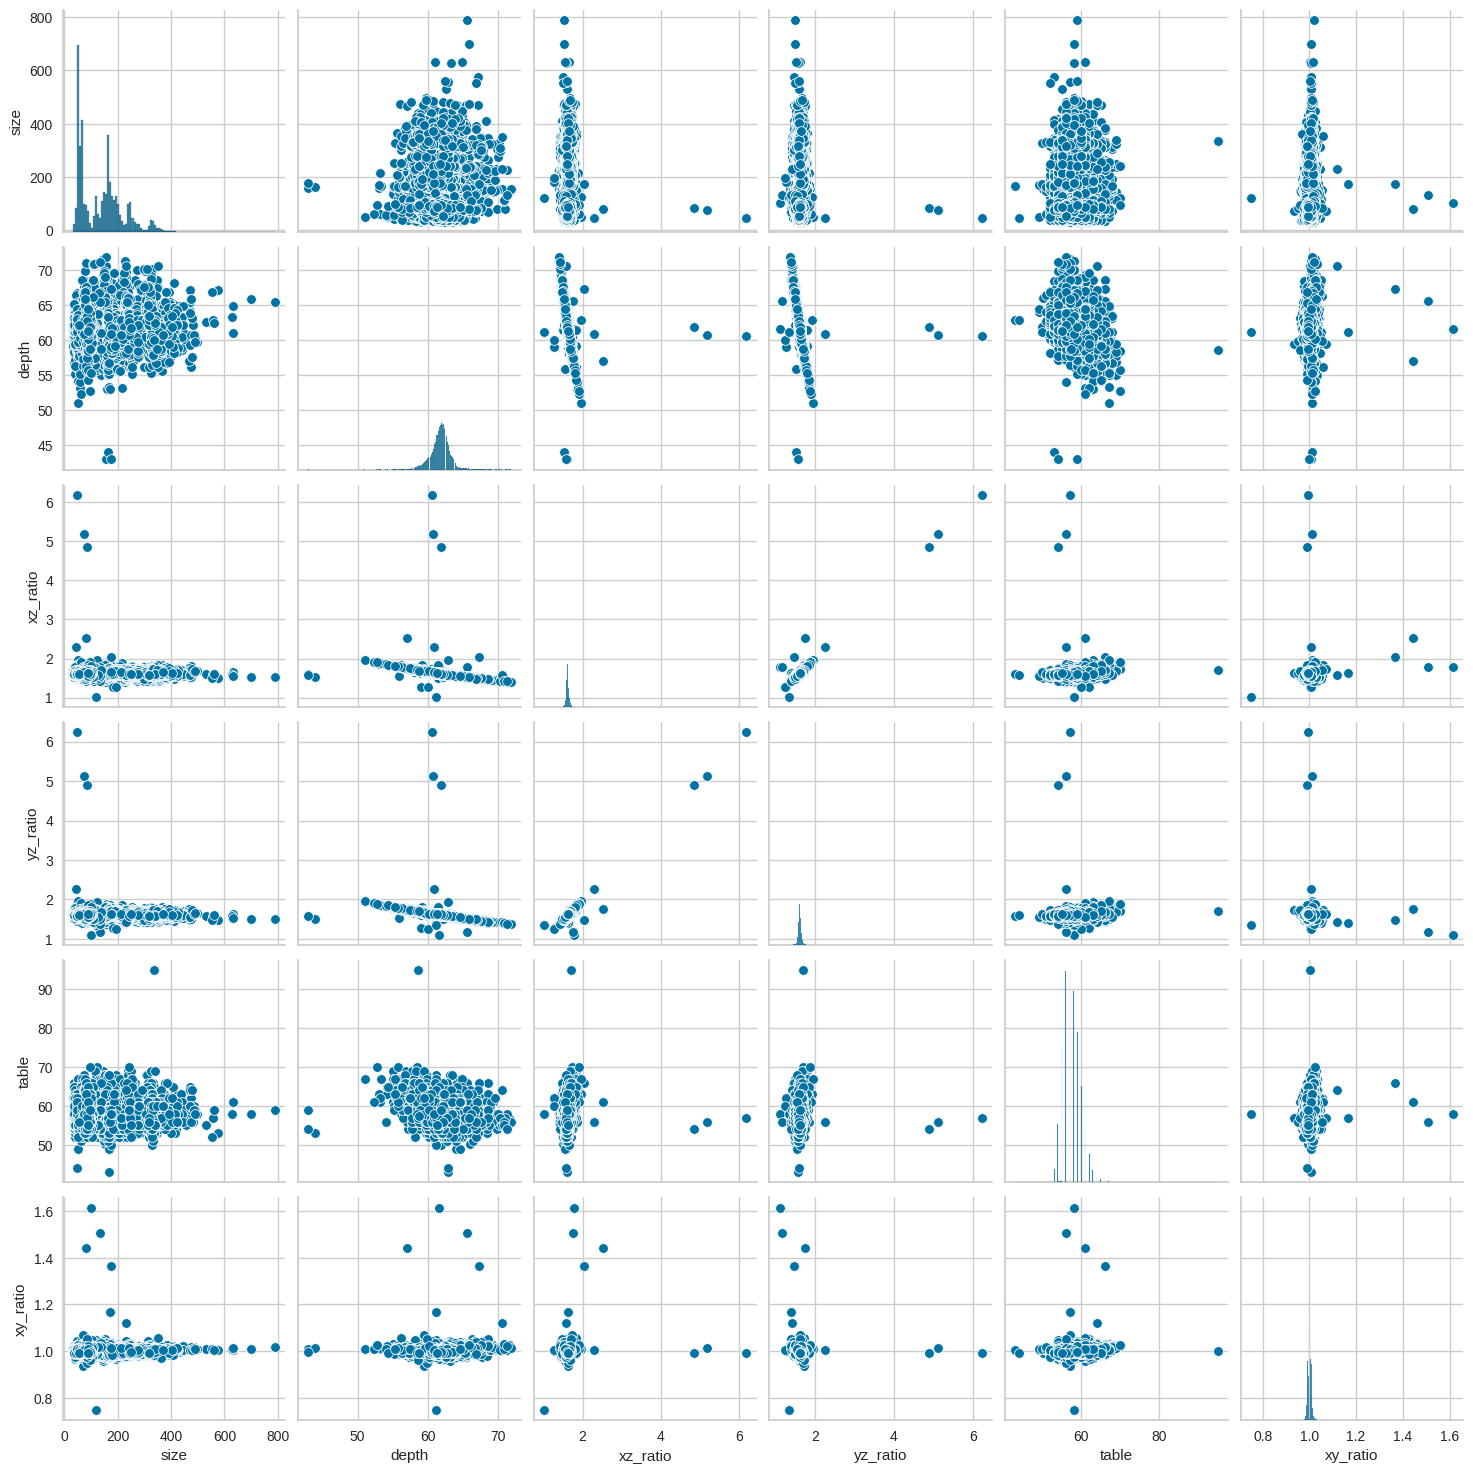

In [ ]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))

sns.pairplot(X_train[num_cols])
plt.show();

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


['yz_ratio', 'feature_2', 'feature_4', 'price']


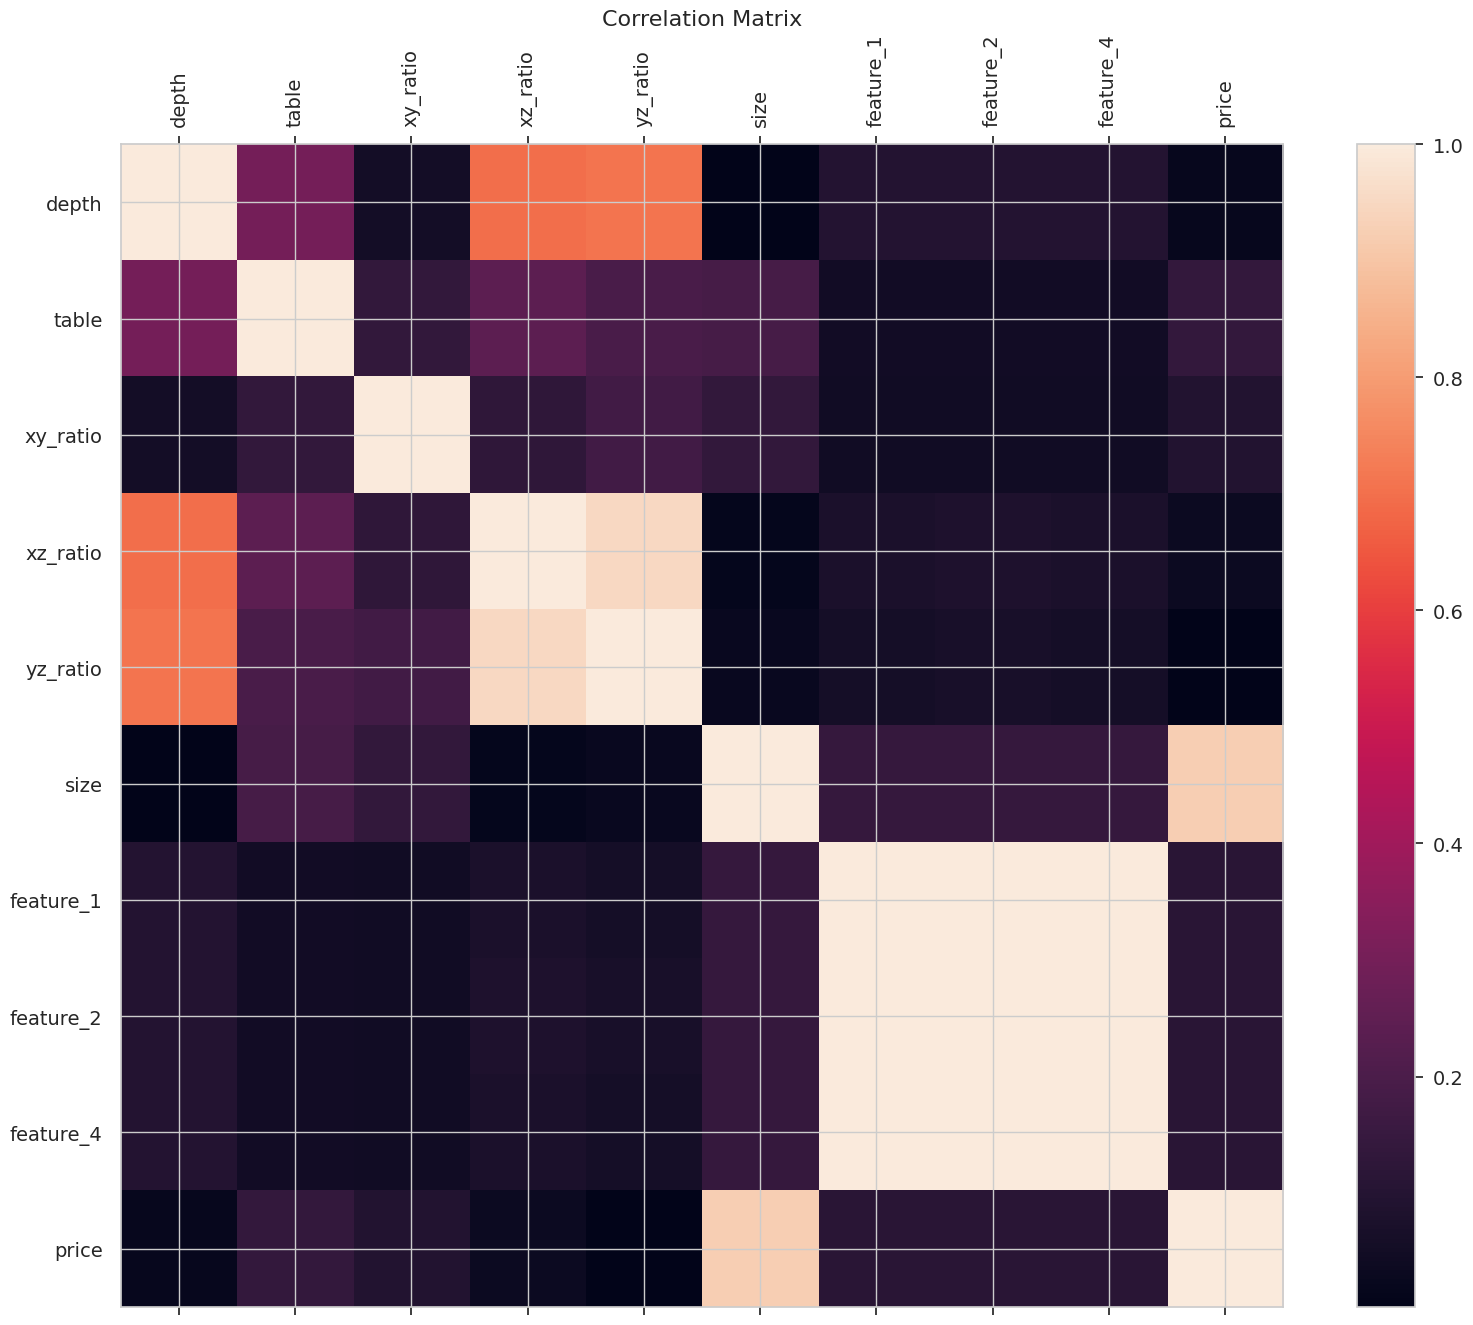

In [ ]:
###################
### Correlation ###
###################

corre_data = pd.concat([X_train[num_cols],
                        pd.DataFrame(y_train)],
                       axis = 1)

cor_matrix = corre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [ ]:
to_drop_vif = ['size','yz_ratio']

try:
    X_train = X_train.drop(to_drop_vif, axis=1)
    X_test = X_test.drop(to_drop_vif, axis=1)
    X_val = X_val.drop(to_drop_vif, axis=1)
except:
    X_train = X_train
    X_test = X_test
    X_val = X_val

In [ ]:
#####################
### MinMax scaler ###
#####################

num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_miss' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))

print(X_train[num_cols].shape)

transformer_train = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(transformer_train.transform(X_train[num_cols]))
num_data_train.columns = num_cols
print(num_data_train.shape)

num_data_test = minmax_dset(X_test,num_cols) ### Test ###
num_data_val = minmax_dset(X_val,num_cols) ### Validation ###

(34509, 4)
(34509, 4)
(10784, 4)
(8627, 4)


#### Categorical data

In [ ]:
cat_cols = list(X_train.select_dtypes(include=['object']))
cat_cols = (list(set(cat_cols) - set([col for col in X_train.columns if '_bin' in col])))
cat_cols = (list(set(cat_cols) - set([col for col in X_train.columns if 'feature_' in col])))
print(cat_cols)

['color', 'clarity', 'cut']


In [ ]:
###################################
### High cardinality adjustment ###
###################################

card_vars = []
cat_data = X_train[cat_cols]
for i in range(cat_data.shape[1]):
    X_train.loc[X_train[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'
    X_test.loc[X_test[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'
    X_val.loc[X_val[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'

    if (cat_data.iloc[:,i].nunique() > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        X_train.loc[~X_train[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'
        X_test.loc[~X_test[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'
        X_val.loc[~X_val[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    if (len(list(set(cat_data.iloc[:,i]))) > 100):
        card_vars.append(cat_data.columns[i])

print(card_vars)

[]


In [ ]:
########################
### One hot encoding ###
########################

ohe = OneHotEncoder()
print(X_train.shape)
# (1808, 10)

### Train ###

ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_train = ohe_dset(X_train,cat_cols)  ### Train ###
cat_data_test = ohe_dset(X_test,cat_cols)    ### Test ###
cat_data_val = ohe_dset(X_val,cat_cols)    ### Validation ###


(34509, 13)
(34509, 20)
(10784, 20)
(8627, 20)


#### Bin data

In [ ]:
bin_data_cols = [col for col in X_train.columns if 'feature_' in col]
print(bin_data_cols)

['feature_1', 'feature_2', 'feature_4']


In [ ]:
bin_data_train = X_train[bin_data_cols]
bin_data_test = X_test[bin_data_cols]
bin_data_val = X_val[bin_data_cols]

print(bin_data_train.shape)

(34509, 3)


#### Ordinal data

In [ ]:
[col for col in X_train.columns if '_bin' in col]

['x_bin', 'y_bin', 'z_bin']

In [ ]:
ordinal_encoder_bin = OrdinalEncoder(categories=[['Missing','0','1','2','3','4','5','6','7','8','9']])
ordinal_encoder_bin.fit(pd.DataFrame(X_train['x_bin']))
ord_data_train = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['x_bin'])),columns = ['x_bin'])
ord_data_test = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['x_bin'])), columns = ['x_bin'])
ord_data_val = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_val['x_bin'])), columns = ['x_bin'])

ordinal_encoder_bin.fit(pd.DataFrame(X_train['y_bin']))
ord_data_train['y_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_train['y_bin']))
ord_data_test['y_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_test['y_bin']))
ord_data_val['y_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_val['y_bin']))

ordinal_encoder_bin.fit(pd.DataFrame(X_train['z_bin']))
ord_data_train['z_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_train['z_bin']))
ord_data_test['z_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_test['z_bin']))
ord_data_val['z_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_val['z_bin']))

for name in ['x_bin', 'y_bin', 'z_bin']:
    ord_data_train[name] = ord_data_train[name].astype(int)
    ord_data_test[name] = ord_data_test[name].astype(int)
    ord_data_val[name] = ord_data_val[name].astype(int)

transformer_train_o = MinMaxScaler().fit(ord_data_train)
ord_data_train = pd.DataFrame(transformer_train_o.transform(ord_data_train))
ord_data_train.columns = ['x_bin', 'y_bin', 'z_bin']

print(
    f'Training data min:max {ord_data_train.min().min(),ord_data_train.max().max()}')

transformer_test_o = MinMaxScaler().fit(ord_data_test)
ord_data_test = pd.DataFrame(transformer_test_o.transform(ord_data_test))
ord_data_test.columns = ['x_bin', 'y_bin', 'z_bin']

transformer_val_o = MinMaxScaler().fit(ord_data_val)
ord_data_val = pd.DataFrame(transformer_val_o.transform(ord_data_val))
ord_data_val.columns = ['x_bin', 'y_bin', 'z_bin']

print(
    f'Test data min:max {ord_data_test.min().min(),ord_data_test.max().max()}')

Training data min:max (0.0, 1.0)
Test data min:max (0.0, 1.0)


In [ ]:
print(list(cat_data_train.columns))

print(list(num_data_train.columns))

print(list(bin_data_train.columns))

print(list(ord_data_train.columns))

['color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2', 'cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good']
['table', 'depth', 'xy_ratio', 'xz_ratio']
['feature_1', 'feature_2', 'feature_4']
['x_bin', 'y_bin', 'z_bin']


In [ ]:
###########################
### Bring data together ###
###########################

print(cat_data_train.shape, num_data_train.shape, bin_data_train.shape, ord_data_train.shape)
cat_data_train = cat_data_train.reset_index()
num_data_train = num_data_train.reset_index()
bin_data_train = bin_data_train.reset_index()
ord_data_train = ord_data_train.reset_index()

X_train = pd.concat([cat_data_train,num_data_train],axis = 1)
print(X_train.shape)
X_train = pd.concat([X_train,bin_data_train],axis = 1)
print(X_train.shape)
X_train = pd.concat([X_train,ord_data_train],axis = 1)

print(cat_data_test.shape, num_data_test.shape, bin_data_test.shape, ord_data_test.shape)
cat_data_test = cat_data_test.reset_index()
num_data_test = num_data_test.reset_index()
bin_data_test = bin_data_test.reset_index()
ord_data_test = ord_data_test.reset_index()
X_test = pd.concat([cat_data_test,num_data_test],axis = 1)
X_test = pd.concat([X_test,bin_data_test],axis = 1)
X_test = pd.concat([X_test,ord_data_test],axis = 1)

print(cat_data_val.shape, num_data_val.shape, bin_data_val.shape, ord_data_val.shape)
cat_data_val = cat_data_val.reset_index()
num_data_val = num_data_val.reset_index()
bin_data_val = bin_data_val.reset_index()
ord_data_val = ord_data_val.reset_index()
X_val = pd.concat([cat_data_val,num_data_val],axis = 1)
X_val = pd.concat([X_val,bin_data_val],axis = 1)
X_val = pd.concat([X_val,ord_data_val],axis = 1)

print(X_train.shape, X_test.shape, X_val.shape)

# (39116, 60) (9779, 60)

(34509, 20) (34509, 4) (34509, 3) (34509, 3)
(34509, 26)
(34509, 30)
(10784, 20) (10784, 4) (10784, 3) (10784, 3)
(8627, 20) (8627, 4) (8627, 3) (8627, 3)
(34509, 34) (10784, 34) (8627, 34)


In [ ]:
####################################################
### Check that train/test sets have same columns ###
####################################################

mod_cols = (list(set(list(X_train.columns)) - set(['index'])))
X_train = X_train[mod_cols]
miss_lst = list(set(list(X_train.columns)) - set(list(X_test.columns)))

for name in miss_lst:
    X_test[name] = 0
X_test = X_test[list(X_train.columns)]

drop_test_lst = list(set(list(X_test.columns)) - set(list(X_train.columns)))
X_test = X_test.drop(drop_test_lst, axis = 1)

miss_lst_val = list(set(list(X_train.columns)) - set(list(X_val.columns)))

for name in miss_lst_val:
    X_val[name] = 0
X_val = X_val[list(X_train.columns)]

drop_val_lst = list(set(list(X_val.columns)) - set(list(X_train.columns)))
X_val = X_val.drop(drop_val_lst, axis = 1)

print(X_train.shape, X_test.shape, X_val.shape)
# (39082, 70) (9770, 70)

(34509, 30) (10784, 30) (8627, 30)


#### Mutual information check

In [ ]:
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns

In [ ]:
mutual_info = mutual_info.sort_values(ascending=False)
mutual_info[:20]

y_bin           1.385673
x_bin           1.382981
z_bin           1.331392
xy_ratio        0.599796
feature_4       0.128722
feature_2       0.128658
feature_1       0.124434
clarity_SI1     0.099665
clarity_VS2     0.092036
clarity_SI2     0.081087
color_E         0.074978
xz_ratio        0.073631
color_G         0.068766
cut_Ideal       0.067011
color_D         0.065955
color_F         0.062381
table           0.061956
clarity_VS1     0.059108
clarity_VVS2    0.057918
clarity_VVS1    0.055561
dtype: float64

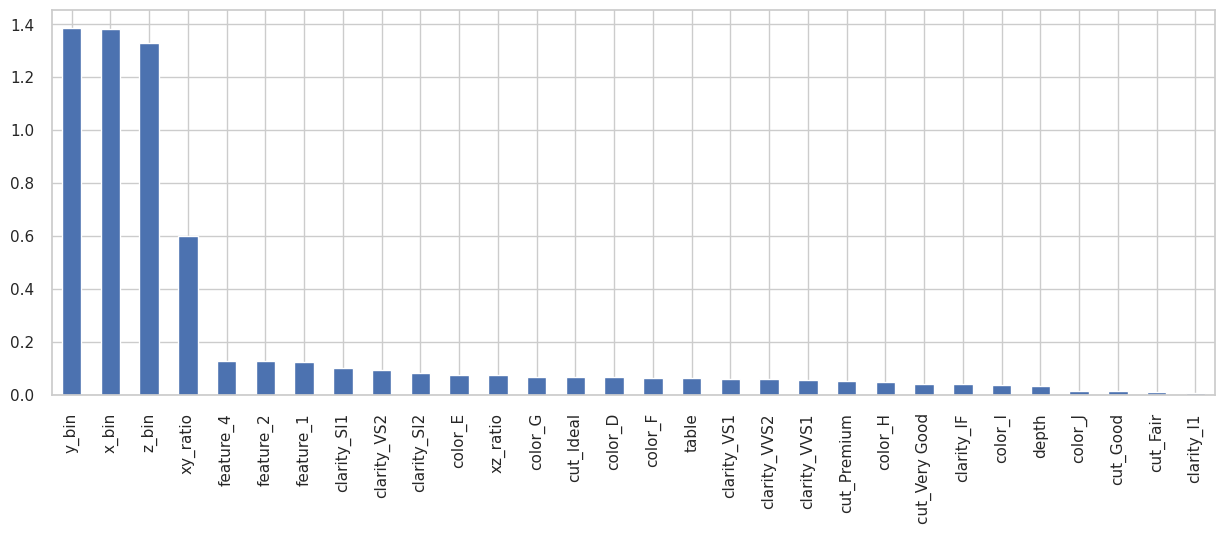

In [ ]:
mutual_info[:50].sort_values(ascending=False).plot.bar(figsize=(15,5))
plt.show()

### Compute Predictions and Shap Values

In [ ]:
def get_preds_shaps(df, features, target):
  model = LGBMRegressor().fit(df.loc[:, features], df.loc[:, target])
  preds = pd.Series(model.predict(df[features]), index=df.index)
  shap_explainer = TreeExplainer(model)
  shaps = pd.DataFrame(
    data=shap_explainer.shap_values(df[features]),
    index=df.index,
    columns=features)
  return preds, shaps

In [ ]:
def get_feature_contributions(y_true, y_pred, shap_values):
  """Compute prediction contribution and error contribution for each feature."""

  prediction_contribution = shap_values.abs().mean().rename("prediction_contribution")

  abs_error = (y_true - y_pred).abs()
  y_pred_wo_feature = shap_values.apply(lambda feature: y_pred - feature)
  abs_error_wo_feature = y_pred_wo_feature.apply(lambda feature: (y_true - feature).abs())
  error_contribution = abs_error_wo_feature.apply(lambda feature: abs_error - feature).mean().rename("error_contribution")

  return prediction_contribution, error_contribution

In [ ]:
X_train = X_train.reset_index()

#y_train = y_train[[col for col in y_train.columns if (col != 'level_0') & (col != 'index')]]
y_train = y_train.reset_index(drop = True)
X_train = X_train[[col for col in X_train.columns if (col != 'level_0') & (col != 'index')]]

X_trainc_data = pd.concat([X_train, y_train], axis = 1)
print(X_train.shape, y_train.shape, X_trainc_data.shape)

(34509, 30) (34509,) (34509, 31)


In [ ]:
print(list(X_trainc_data.columns))

['z_bin', 'feature_1', 'clarity_VVS2', 'cut_Ideal', 'color_E', 'x_bin', 'color_J', 'color_I', 'xz_ratio', 'table', 'clarity_IF', 'clarity_SI1', 'color_G', 'feature_2', 'cut_Good', 'cut_Premium', 'clarity_VS2', 'clarity_SI2', 'clarity_VS1', 'color_F', 'color_H', 'feature_4', 'color_D', 'cut_Very Good', 'cut_Fair', 'clarity_I1', 'clarity_VVS1', 'xy_ratio', 'y_bin', 'depth', 'price']


In [ ]:
from shap import TreeExplainer

X_valc_data = pd.concat([X_val, y_val], axis = 1)
features_train = list(X_train.columns)
features_val = list(X_val.columns)
target = 'price'

preds_train, shaps_train = get_preds_shaps(df = X_trainc_data, features = features_train, target = target)
preds_val, shaps_val = get_preds_shaps(df = X_valc_data, features = features_val, target = target)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 41415, number of used features: 30
[LightGBM] [Info] Start training from score 3709.740336
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 15533, number of used features: 30
[LightGBM] [Info] Start training from score 2447.268010


In [ ]:
prediction_contribution_trn, error_contribution_trn = get_feature_contributions(
  y_true = X_trainc_data.loc[:, target],
  y_pred = preds_train,
  shap_values = shaps_train
)

prediction_contribution_val, error_contribution_val = get_feature_contributions(
  y_true = X_valc_data.loc[:, target],
  y_pred = preds_val,
  shap_values = shaps_val
)

contributions_trn = pd.concat([prediction_contribution_trn, error_contribution_trn], axis=1)
contributions_val = pd.concat([prediction_contribution_val, error_contribution_val], axis=1)

#### Train set

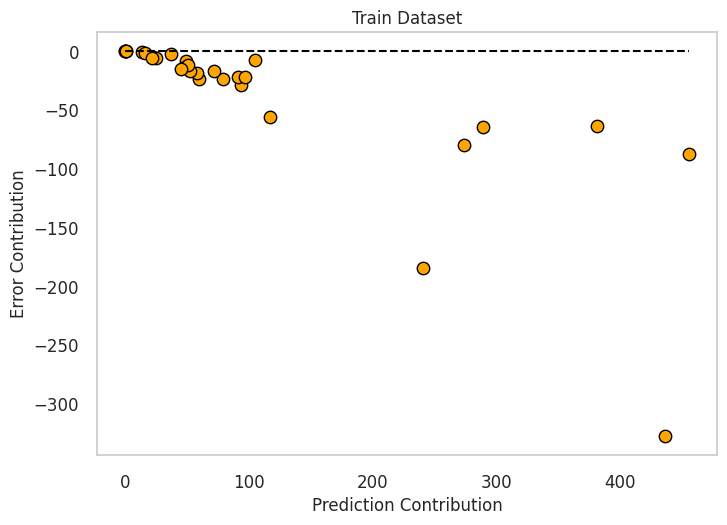

In [ ]:
fig, ax = plt.subplots()

ax.scatter(contributions_trn["prediction_contribution"], contributions_trn["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_trn["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)
ax.grid(); ax.set_axisbelow(True)
ax.set_title("Train Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_trn.png", dpi=200, bbox_inches="tight")

In [ ]:
pd.set_option("display.max_rows", 10)

contributions_trn.sort_values("prediction_contribution", ascending=False).head(10)

,prediction_contribution,error_contribution
z_bin,455.409323,-87.532668
depth,435.940444,-327.592249
x_bin,380.749132,-63.644138
y_bin,289.115274,-64.925555
xy_ratio,274.068424,-80.187026
clarity_I1,240.371575,-184.120794
table,116.907820,-56.361056
clarity_SI2,105.145104,-7.939550
clarity_VS2,96.575920,-22.035476
color_I,93.230908,-28.695924


In [ ]:
pd.set_option("display.max_rows", 10)

contributions_trn.sort_values("prediction_contribution", ascending=True).head(10)

,prediction_contribution,error_contribution
feature_2,0.000000,0.000000
feature_4,0.000000,0.000000
feature_1,0.421733,-0.120981
cut_Fair,0.788790,-0.240775
cut_Ideal,13.316240,-1.023051
cut_Premium,15.623967,-1.934294
color_F,21.965088,-5.576103
clarity_VVS2,22.347985,-5.155268
color_E,25.169567,-5.779201
cut_Very Good,36.565184,-2.276990


#### Validation set

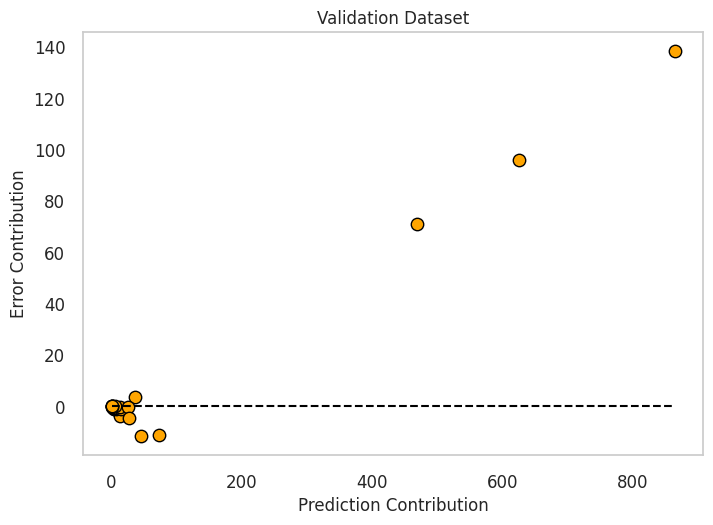

In [ ]:
fig, ax = plt.subplots()

ax.scatter(contributions_val["prediction_contribution"], contributions_val["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_val["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)

ax.grid()
ax.set_axisbelow(True)
ax.set_title("Validation Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_val.png", dpi=200, bbox_inches="tight")

In [ ]:
pd.set_option("display.max_rows", 10)

contributions_val.sort_values("error_contribution", ascending=True).round(4).head(10)

,prediction_contribution,error_contribution
xz_ratio,45.4791,-11.6777
xy_ratio,72.3903,-11.1053
y_bin,26.6744,-4.5486
color_G,12.9159,-3.7852
x_bin,8.9742,-1.5159
cut_Ideal,5.1963,-1.2187
color_H,13.9982,-1.1604
color_E,4.6877,-0.9799
clarity_SI1,4.1267,-0.9632
clarity_VS1,6.9637,-0.9184


In [ ]:
pd.set_option("display.max_rows", 10)

contributions_val.sort_values("error_contribution", ascending=False).round(4).head(10)

,prediction_contribution,error_contribution
z_bin,865.6113,138.3981
table,625.0771,95.9625
depth,469.5176,71.0676
clarity_IF,36.1321,3.5866
cut_Very Good,5.0133,0.0698
clarity_I1,0.2244,0.0199
feature_4,0.0000,0.0000
feature_2,0.0000,0.0000
color_J,1.3997,-0.0563
clarity_VS2,3.3898,-0.1357


#### RFE - Error Contribution

In [ ]:
print(X_trainc_data.shape)

(41415, 31)


In [ ]:
rfe_error = pd.DataFrame(dtype=float)
features_curr = features_train.copy()
feature_drop = None
df = X_trainc_data.copy()
df = df.reset_index()

for iteration in tqdm(range(len(features_train))):

  preds_train, shaps_train = get_preds_shaps(df = df, features = features_curr, target = target)
  prediction_contribution, error_contribution = get_feature_contributions(
    y_true = df.loc[:, target],
    y_pred = preds_train,
    shap_values = shaps_train
  )

  rfe_error.loc[iteration, "feature_drop"] = feature_drop
  rfe_error.loc[iteration, "n_features"] = len(features_curr)
  rfe_error.loc[iteration, "contrib"] = error_contribution.max()
  rfe_error.loc[iteration, "mae_trn"] = mean_absolute_error(y_train, preds_train)
  rfe_error.loc[iteration, "r2_trn"] = r2_score(y_train, preds_train)

  feature_drop = error_contribution.idxmax()
  features_curr.remove(feature_drop)

  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 821
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 30
[LightGBM] [Info] Start training from score 4452.139906


  3%|▎         | 1/30 [00:35<17:09, 35.51s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 29
[LightGBM] [Info] Start training from score 4452.139906


  7%|▋         | 2/30 [01:12<16:58, 36.38s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 28
[LightGBM] [Info] Start training from score 4452.139906


 10%|█         | 3/30 [01:47<16:01, 35.61s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 27
[LightGBM] [Info] Start training from score 4452.139906


 13%|█▎        | 4/30 [02:23<15:31, 35.81s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 26
[LightGBM] [Info] Start training from score 4452.139906


 17%|█▋        | 5/30 [03:00<15:11, 36.45s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 811
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 25
[LightGBM] [Info] Start training from score 4452.139906


 20%|██        | 6/30 [03:36<14:31, 36.33s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 24
[LightGBM] [Info] Start training from score 4452.139906


 23%|██▎       | 7/30 [04:12<13:47, 35.96s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 23
[LightGBM] [Info] Start training from score 4452.139906


 27%|██▋       | 8/30 [04:48<13:14, 36.13s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 22
[LightGBM] [Info] Start training from score 4452.139906


 30%|███       | 9/30 [05:21<12:18, 35.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 21
[LightGBM] [Info] Start training from score 4452.139906


 33%|███▎      | 10/30 [05:54<11:28, 34.42s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 20
[LightGBM] [Info] Start training from score 4452.139906


 37%|███▋      | 11/30 [06:27<10:45, 33.99s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 19
[LightGBM] [Info] Start training from score 4452.139906


 40%|████      | 12/30 [06:58<09:57, 33.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 18
[LightGBM] [Info] Start training from score 4452.139906


 43%|████▎     | 13/30 [07:29<09:12, 32.51s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 17
[LightGBM] [Info] Start training from score 4452.139906


 47%|████▋     | 14/30 [07:59<08:25, 31.59s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 309
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 16
[LightGBM] [Info] Start training from score 4452.139906


 50%|█████     | 15/30 [08:28<07:44, 30.97s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 15
[LightGBM] [Info] Start training from score 4452.139906


 53%|█████▎    | 16/30 [08:57<07:05, 30.37s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 14
[LightGBM] [Info] Start training from score 4452.139906


 57%|█████▋    | 17/30 [09:26<06:26, 29.71s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 13
[LightGBM] [Info] Start training from score 4452.139906


 60%|██████    | 18/30 [09:53<05:48, 29.03s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 12
[LightGBM] [Info] Start training from score 4452.139906


 63%|██████▎   | 19/30 [10:21<05:17, 28.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 11
[LightGBM] [Info] Start training from score 4452.139906


 67%|██████▋   | 20/30 [10:47<04:39, 27.95s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 10
[LightGBM] [Info] Start training from score 4452.139906


 70%|███████   | 21/30 [11:13<04:04, 27.19s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 9
[LightGBM] [Info] Start training from score 4452.139906


 73%|███████▎  | 22/30 [11:35<03:25, 25.73s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 8
[LightGBM] [Info] Start training from score 4452.139906


 77%|███████▋  | 23/30 [11:57<02:51, 24.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 7
[LightGBM] [Info] Start training from score 4452.139906


 80%|████████  | 24/30 [12:19<02:23, 23.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 6
[LightGBM] [Info] Start training from score 4452.139906


 83%|████████▎ | 25/30 [12:42<01:57, 23.47s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 5
[LightGBM] [Info] Start training from score 4452.139906


 87%|████████▋ | 26/30 [13:00<01:27, 21.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 4
[LightGBM] [Info] Start training from score 4452.139906


 90%|█████████ | 27/30 [13:17<01:01, 20.37s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 3
[LightGBM] [Info] Start training from score 4452.139906


 93%|█████████▎| 28/30 [13:31<00:37, 18.59s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 2
[LightGBM] [Info] Start training from score 4452.139906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

 97%|█████████▋| 29/30 [13:41<00:16, 16.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 1
[LightGBM] [Info] Start training from score 4452.139906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

100%|██████████| 30/30 [13:44<00:00, 27.47s/it]


#### RFE - Prediction Contribution

In [ ]:
rfe_prediction = pd.DataFrame(dtype=float)
features_curr = features_train.copy()
feature_drop = None

for iteration in tqdm(range(len(features_train))):

  preds_train, shaps_train = get_preds_shaps(df = df, features = features_curr, target = target)
  prediction_contribution, error_contribution = get_feature_contributions(
    y_true=df.loc[:, target],
    y_pred=preds_train,
    shap_values=shaps_train
  )

  rfe_prediction.loc[iteration, "feature_drop"] = feature_drop
  rfe_prediction.loc[iteration, "n_features"] = len(features_curr)
  rfe_prediction.loc[iteration, "contrib"] = prediction_contribution.min()
  rfe_prediction.loc[iteration, "mae_trn"] = mean_absolute_error(df.loc[:, target], preds_train)
  rfe_prediction.loc[iteration, "r2_trn"] = r2_score(df.loc[:, target], preds_train)

  feature_drop = prediction_contribution.idxmin()
  features_curr.remove(feature_drop)

  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 821
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 30
[LightGBM] [Info] Start training from score 4452.139906


  3%|▎         | 1/30 [00:34<16:52, 34.91s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 29
[LightGBM] [Info] Start training from score 4452.139906


  7%|▋         | 2/30 [01:11<16:43, 35.86s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 28
[LightGBM] [Info] Start training from score 4452.139906


 10%|█         | 3/30 [01:46<15:52, 35.27s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 27
[LightGBM] [Info] Start training from score 4452.139906


 13%|█▎        | 4/30 [02:23<15:39, 36.12s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 26
[LightGBM] [Info] Start training from score 4452.139906


 17%|█▋        | 5/30 [03:00<15:10, 36.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 811
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 25
[LightGBM] [Info] Start training from score 4452.139906


 20%|██        | 6/30 [03:37<14:37, 36.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 24
[LightGBM] [Info] Start training from score 4452.139906


 23%|██▎       | 7/30 [04:12<13:50, 36.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 23
[LightGBM] [Info] Start training from score 4452.139906


 27%|██▋       | 8/30 [04:48<13:16, 36.21s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 22
[LightGBM] [Info] Start training from score 4452.139906


 30%|███       | 9/30 [05:22<12:21, 35.31s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 21
[LightGBM] [Info] Start training from score 4452.139906


 33%|███▎      | 10/30 [05:55<11:32, 34.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 20
[LightGBM] [Info] Start training from score 4452.139906


 37%|███▋      | 11/30 [06:27<10:42, 33.81s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 19
[LightGBM] [Info] Start training from score 4452.139906


 40%|████      | 12/30 [06:59<10:02, 33.45s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 18
[LightGBM] [Info] Start training from score 4452.139906


 43%|████▎     | 13/30 [07:31<09:20, 33.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 17
[LightGBM] [Info] Start training from score 4452.139906


 47%|████▋     | 14/30 [08:01<08:31, 31.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 309
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 16
[LightGBM] [Info] Start training from score 4452.139906


 50%|█████     | 15/30 [08:32<07:53, 31.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 15
[LightGBM] [Info] Start training from score 4452.139906


 53%|█████▎    | 16/30 [09:01<07:12, 30.90s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 14
[LightGBM] [Info] Start training from score 4452.139906


 57%|█████▋    | 17/30 [09:30<06:33, 30.25s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 13
[LightGBM] [Info] Start training from score 4452.139906


 60%|██████    | 18/30 [09:58<05:55, 29.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 12
[LightGBM] [Info] Start training from score 4452.139906


 63%|██████▎   | 19/30 [10:22<05:09, 28.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 11
[LightGBM] [Info] Start training from score 4452.139906


 67%|██████▋   | 20/30 [10:50<04:38, 27.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 10
[LightGBM] [Info] Start training from score 4452.139906


 70%|███████   | 21/30 [11:15<04:03, 27.09s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 9
[LightGBM] [Info] Start training from score 4452.139906


 73%|███████▎  | 22/30 [11:37<03:25, 25.65s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 8
[LightGBM] [Info] Start training from score 4452.139906


 77%|███████▋  | 23/30 [12:04<03:02, 26.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 7
[LightGBM] [Info] Start training from score 4452.139906


 80%|████████  | 24/30 [12:29<02:34, 25.71s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 6
[LightGBM] [Info] Start training from score 4452.139906


 83%|████████▎ | 25/30 [12:50<02:01, 24.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 5
[LightGBM] [Info] Start training from score 4452.139906


 87%|████████▋ | 26/30 [13:10<01:31, 22.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 4
[LightGBM] [Info] Start training from score 4452.139906


 90%|█████████ | 27/30 [13:28<01:04, 21.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 3
[LightGBM] [Info] Start training from score 4452.139906


 93%|█████████▎| 28/30 [13:43<00:38, 19.44s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 2
[LightGBM] [Info] Start training from score 4452.139906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

 97%|█████████▋| 29/30 [13:51<00:16, 16.09s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 34509, number of used features: 1
[LightGBM] [Info] Start training from score 4452.139906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

100%|██████████| 30/30 [13:53<00:00, 27.79s/it]


FixedFormatter should only be used together with FixedLocator


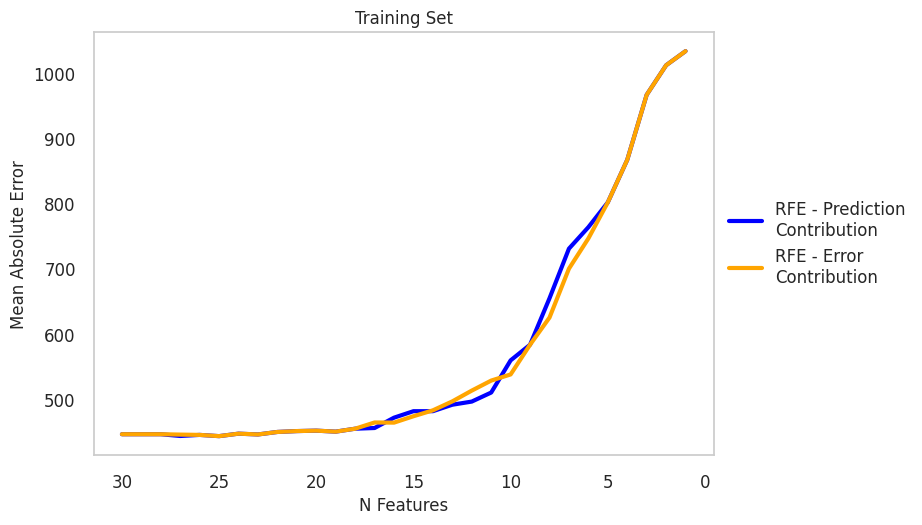

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(-rfe_prediction["n_features"], rfe_prediction["mae_trn"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error["n_features"], rfe_error["mae_trn"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.set_title("Training Set", fontsize=12)
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

#fig.savefig("rfe_val_all.png", dpi=200, bbox_inches="tight")

FixedFormatter should only be used together with FixedLocator


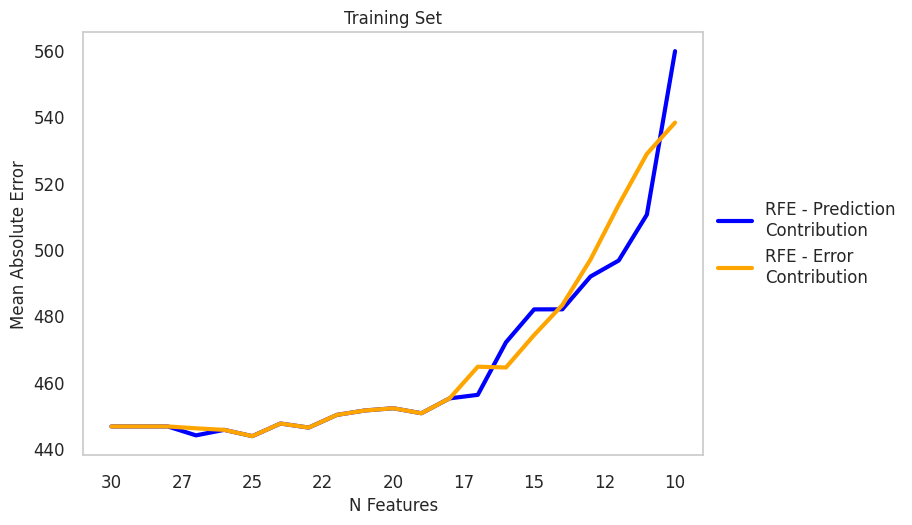

In [ ]:
max_iter_show = len(rfe_error) - 9

fig, ax = plt.subplots()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["mae_trn"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["mae_trn"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.set_title("Training Set")
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

#fig.savefig("rfe_trn.png", dpi=200, bbox_inches="tight")

FixedFormatter should only be used together with FixedLocator


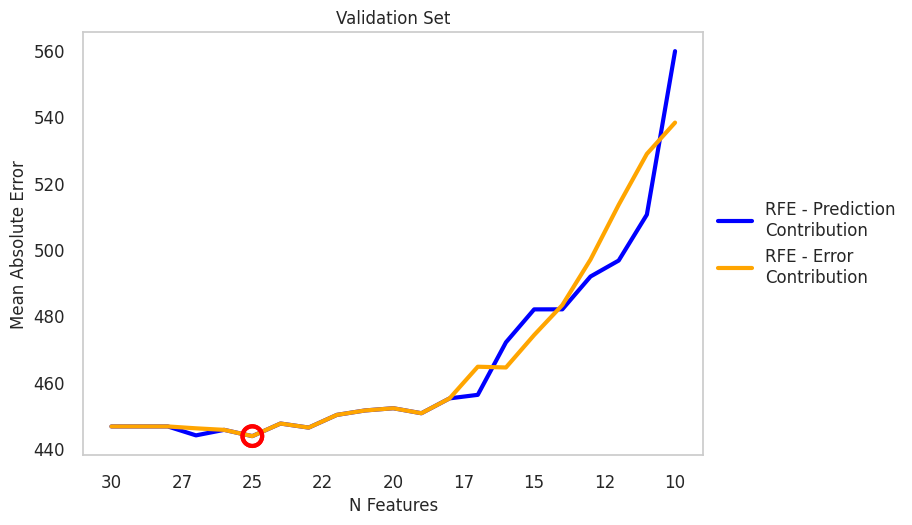

In [ ]:
fig, ax = plt.subplots()

idxmin_prediction = rfe_prediction["mae_trn"].idxmin()
idxmin_error = rfe_error["mae_trn"].idxmin()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["mae_trn"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["mae_trn"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.scatter(-rfe_prediction.loc[idxmin_prediction,"n_features"], rfe_prediction.loc[idxmin_prediction,"mae_trn"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmin_error,"n_features"], rfe_error.loc[idxmin_error,"mae_trn"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Training Set", fontsize=12)
ax.set_ylabel("Mean Absolute Error", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

### Clustering

In [ ]:
clust_data = df[~df.isnull().any(axis=1)]
print(clust_data.shape)
print(list(clust_data.columns))

In [ ]:
#clust_data = clust_data.drop(['name','host_id'], axis = 1)

cat_cols = list(clust_data.select_dtypes(include=['object']))
print('Object data: ', cat_cols)

print('Datetime data: ',list(clust_data.select_dtypes(include=['datetime']).columns))

print('Timedelta data: ',list(clust_data.select_dtypes(include=['timedelta']).columns))

num_cols = list(clust_data.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
print('Numeric data: ', num_cols)

In [ ]:
num_data = clust_data[list(clust_data.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)]
print(num_data.shape)
# (74869, 21)
num_data.describe()

In [ ]:
#####################
### Normalisation ###
#####################

numerical_features = pd.DataFrame(MinMaxScaler(feature_range=(0, 1)).fit_transform(
    num_data[num_cols]), index=num_data.index, columns=num_cols)

print(
    f'Data min:max {numerical_features.min().min(),numerical_features.max().max()}')

In [ ]:
###################################
### High cardinality adjustment ###
###################################

card_vars = []
cat_data = clust_data[cat_cols]
cat_data_vals = cat_data.copy()
for i in range(cat_data.shape[1]):

    if (len(list(set(cat_data.iloc[:,i]))) > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        cat_data_vals.loc[~cat_data_vals[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    elif cat_data.iloc[:,i].nunique() > 100:
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))
        card_vars.append(cat_data.columns[i])

print(card_vars)

In [ ]:
ohe = OneHotEncoder()

transformed_dset = ohe.fit_transform(cat_data_vals[cat_cols])
cat_data = pd.DataFrame(transformed_dset.toarray())
cat_data.columns = ohe.get_feature_names_out(input_features=cat_data_vals[cat_cols].columns)

In [ ]:
#cat_data = cat_data.drop(['gender_Person'], axis = 1)
print(cat_data.shape)
print(list(cat_data.columns))
print(
    f'Data min:max {cat_data.min().min(),cat_data.max().max()}')

In [ ]:
numerical_features = numerical_features.reset_index(drop=True)
cat_data = cat_data.reset_index(drop=True)
print(list(numerical_features.columns))
print(list(cat_data.columns))
all_data = pd.concat([numerical_features,cat_data], axis = 1)
print(all_data.shape)

In [ ]:
objective_function = []
for i in tqdm(range(1, 20)):
    clustering = KMeans(n_clusters=i, init='k-means++')
    clustering.fit(all_data)
    objective_function.append(clustering.inertia_)

plt.plot(range(1, 20), objective_function)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters K')
plt.ylabel('Objective_function')
plt.show()

In [ ]:
###########
### PCA ###
###########

pca = PCA()
pca.fit(all_data)

plt.figure(figsize=(10,8))
plt.plot(range(1,len(pca.explained_variance_ratio_.cumsum())+1), pca.explained_variance_ratio_.cumsum(),
         marker='o',linestyle='--')
plt.title("Explained variance by components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show();

In [ ]:
pca = PCA(n_components=11)
pca.fit(all_data)
scores_pca = pca.transform(all_data)

In [ ]:
wcss = []
for i in tqdm(range(1,40)):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(wcss)+1), wcss,
         marker='o', linestyle='--')
plt.title("K means with PCA - First Iteration")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show();

In [ ]:
tuned_clustering = KMeans(n_clusters=12, init='k-means++', random_state=0)
labels = tuned_clustering.fit_predict(all_data)

metrics.silhouette_score(
    all_data, tuned_clustering.labels_, metric='euclidean')

In [ ]:
for i in tqdm([5, 6, 7]):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(all_data)

In [ ]:
kmeans_pca = KMeans(n_clusters=12, init="k-means++", random_state=42)
kmeans_pca.fit(scores_pca)
df_segm_pca_means = pd.concat(
    [all_data.reset_index(drop=True), pd.DataFrame(scores_pca)],axis=1)

df_segm_pca_means.columns.values[-11:] = ['Component 1', 'Component 2','Component 3',
                                         'Component 4','Component 5','Component 6', 'Component 7','Component 8',
                                         'Component 9','Component 10','Component 11']
df_segm_pca_means['Clusters'] = kmeans_pca.labels_
plt.show()

In [ ]:
pd.crosstab(kmeans_pca.labels_, columns='Count')

In [ ]:
x_axis = df_segm_pca_means['Component 1']
y_axis = df_segm_pca_means['Component 2']
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segm_pca_means['Clusters'], palette="bright")
plt.title("K means with PCA")
plt.show();

#### Calculate important columns

In [ ]:
a = list(all_data.columns)
try:
    a.remove('index')
except:
    a = list(all_data.columns)

clust_check = df_segm_pca_means.groupby(['Clusters']).mean()
clust_checks = clust_check[a]
print(clust_checks.shape)
clust_checks

In [ ]:
for name in a:

    mean_val = np.mean(clust_checks[name])
    clust_checks[str('Index_') + str(name)] = (clust_checks[name]/mean_val) * 100


In [ ]:
import_col = []
index_col = [col for col in clust_checks if col.startswith('Index')]
for name in index_col:
    if ((min(clust_checks[name]) < 60) | (max(clust_checks[name]) > 250)) & (min(clust_checks[name]) != 0):
        import_col.append(name)


In [ ]:
print(len(import_col), import_col)

In [ ]:
cluster_index = pd.concat(
    [clust_checks[import_col], df_segm_pca_means['Clusters']], axis=1)

In [ ]:
import_cols = [re.sub('^Index_', "", x) for x in cluster_index.columns]
import_cols.remove('Clusters')
print(import_cols)

#### Second iteration

In [ ]:
all_data2 = all_data[import_cols]
print(all_data2.shape)
print(
    f'Data min:max {all_data2.min().min(),all_data2.max().max()}')

In [ ]:
###########
### PCA ###
###########

pca2 = PCA()
pca2.fit(all_data2)
plt.figure(figsize=(10,8))
plt.plot(range(1,len(pca2.explained_variance_ratio_.cumsum())+1), pca2.explained_variance_ratio_.cumsum(),
         marker='o',linestyle='--')
plt.title("Explained variance by components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show();

In [ ]:
pca2 = PCA(n_components=2)
pca2.fit(all_data2)
scores_pca2 = pca2.transform(all_data2)

In [ ]:
wcss = []
for i in tqdm(range(1,40)):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans_pca.fit(scores_pca2)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(wcss)+1), wcss,
         marker='o', linestyle='--')
plt.title("K means with PCA - First Iteration")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show();

In [ ]:
kmeans_pca2 = KMeans(n_clusters=3, init="k-means++", random_state=42)
kmeans_pca2.fit(scores_pca2)
df_segm_pca_means2 = pd.concat(
    [all_data2.reset_index(drop=True), pd.DataFrame(scores_pca2)], axis=1)
df_segm_pca_means2.columns.values[-2:] = ['Component 1', 'Component 2']

df_segm_pca_means2['Clusters'] = kmeans_pca2.labels_

In [ ]:
x_axis = df_segm_pca_means2['Component 1']
y_axis = df_segm_pca_means2['Component 2']
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=x_axis, y=y_axis, hue=df_segm_pca_means2['Clusters'], palette="bright")
plt.title("K means with PCA")
plt.show()

#### Important columns

In [ ]:
a = list(all_data2.columns)
try:
    a.remove('index')
except:
    a = list(all_data2.columns)

clust_check2 = df_segm_pca_means2.groupby(['Clusters']).mean()
clust_checks2 = clust_check2[a]
print(clust_checks2.shape)
clust_checks2

In [ ]:
for name in a:

    mean_val = np.mean(clust_checks2[name])
    clust_checks2[str('Index_') + str(name)] = (clust_checks2[name]/mean_val) * 100

In [ ]:
import_col2 = []
index_col = [col for col in clust_checks2 if col.startswith('Index')]
for name in index_col:
    if ((min(clust_checks2[name]) < 60) | (max(clust_checks2[name]) > 250)) & (min(clust_checks2[name]) != 0):
        import_col2.append(name)

print(len(import_col2), import_col2)


In [ ]:
clust_checks3 = clust_checks2.sort_values(by='price')
clust_checks3[index_col]

### Models

#### Gradient Boosting Regressor

In [ ]:
gbr = GradientBoostingRegressor(random_state=0)

In [ ]:
GradientBoostingRegressor().get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
gbr_param_grid = {
    'learning_rate': [0.1,  0.01],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [4, 6],
    'min_samples_leaf': [2, 4]
}

gbr_gridsearch = GridSearchCV(gbr, gbr_param_grid, cv = 5, verbose = 2)

gbr_gridsearch.fit(X_train, y_train)

print("Best parameters: ", gbr_gridsearch.best_params_)
# Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
print("Cross Validation Score: ", gbr_gridsearch.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.6s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   8.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   8.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  15.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  15.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total

KeyboardInterrupt: ignored

In [ ]:
gbr_hyp = GradientBoostingRegressor(random_state=0,
                                    learning_rate = gbr_gridsearch.best_params_['learning_rate'],
                                    n_estimators = gbr_gridsearch.best_params_['n_estimators'],
                                    max_depth = gbr_gridsearch.best_params_['max_depth'],
                                    min_samples_split = gbr_gridsearch.best_params_['min_samples_split'],
                                    min_samples_leaf = gbr_gridsearch.best_params_['min_samples_leaf'])

In [ ]:
gbr_valid_score = gbr_gridsearch.score(X_test, y_test)

print("Validation Score: ", gbr_valid_score)

gbr_hyp.fit(X_train, y_train)

# MAE:  2.230827876694104
# RMSE:  3.1949612716361906

gbr_mae, gbr_rmse, gbr_r2 = diag_vals(gbr_hyp)

#### Adaboost Regressor

In [ ]:
AdaBoostRegressor().get_params().keys()

dict_keys(['base_estimator', 'estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [ ]:
%%time

abr = AdaBoostRegressor()

abr_param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 400],
    'loss' : ['linear', 'square', 'exponential']
}

abr_gridsearch = GridSearchCV(abr, abr_param_grid, cv = 3, verbose = 2)

abr_gridsearch.fit(X_train, y_train)

print("Best parameters: ", abr_gridsearch.best_params_)
# Best parameters:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 200}
# Cross Validation Score:  -1.2408225206059365
print("Cross Validation Score: ", abr_gridsearch.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=100; total time=   3.3s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=100; total time=   8.3s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=100; total time=   6.5s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=200; total time=   3.4s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=200; total time=  14.2s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=200; total time=   7.9s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=300; total time=   4.0s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=300; total time=  27.2s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=300; total time=  13.0s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=400; total time=   3.4s
[CV] END ...learning_rate=0.4, loss=linear, n_estimators=400; total time=  26.6s
[CV] END ...learning_rate=0.4, loss=linear, n_e

In [ ]:
abr_hyp = AdaBoostRegressor(random_state=0,
                            learning_rate = abr_gridsearch.best_params_['learning_rate'],
                            n_estimators = abr_gridsearch.best_params_['n_estimators'],
                            loss = abr_gridsearch.best_params_['loss'])

In [ ]:
abr_valid_score = abr_gridsearch.score(X_test, y_test)

print("Validation Score: ", abr_valid_score)
# Validation Score:  0.8290031404311673

abr_hyp.fit(X_train, y_train)

y_pred_abr = abr_hyp.predict(X_test)

# MAE:  1099.7760296621584
# RMSE:  1640.6106534592402
# R2 score:  0.8306883713222454

abr_mae, abr_rmse, abr_r2 = diag_vals(abr_hyp)

Validation Score:  0.8290031404311673
MAE:  1099.7760296621584
RMSE:  1640.6106534592402
R2 score:  0.8306883713222454


#### Light GBM Regressor

In [ ]:
lg.LGBMRegressor().get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [ ]:
%%time

lgb = lg.LGBMRegressor()

lgb_param_grid = {
    'num_leaves' : [100, 200],
    'min_data_in_leaf': [100, 500],
    'max_bin' : [200, 300, 500],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [5, 7, 9],
    'n_estimators': [100, 200, 400]
}

lgb_gridsearch = GridSearchCV(lgb, lgb_param_grid, cv = 5, verbose = 2)

lgb_gridsearch.fit(X_train, y_train)

print("Best parameters: ", lgb_gridsearch.best_params_)

# Best parameters:  {'learning_rate': 0.1, 'max_bin': 200, 'max_depth': 9, 'min_data_in_leaf': 100, 'n_estimators': 400, 'num_leaves': 100}
# Cross Validation Score:  0.4546637609925588
# CPU times: user 30min 10s, sys: 37.8 s, total: 30min 48s
# Wall time: 31min 1s

print("Cross Validation Score: ", lgb_gridsearch.best_score_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
lgb_hyp = lg.LGBMRegressor(random_state=0,
                            num_leaves = lgb_gridsearch.best_params_['num_leaves'],
                            min_data_in_leaf = lgb_gridsearch.best_params_['min_data_in_leaf'],
                            max_bin = lgb_gridsearch.best_params_['max_bin'],
                            learning_rate = lgb_gridsearch.best_params_['learning_rate'],
                            n_estimators = lgb_gridsearch.best_params_['n_estimators'],
                            max_depth = lgb_gridsearch.best_params_['max_depth'])

In [ ]:
lgb_valid_score = lgb_gridsearch.score(X_test, y_test)

print("Validation Score: ", lgb_valid_score)
# Validation Score:  0.9563971861296531

lgb_hyp.fit(X_train, y_train)

y_pred_lgb = lgb_hyp.predict(X_test)

# MAE:  429.05314980113775
# RMSE:  832.5673817994269
# R2 score:  0.9563971861296531

lgb_mae, lgb_rmse, lgb_r2 = diag_vals(lgb_hyp)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Validation Score:  0.9563971861296531
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 43136, number of used features: 30
[LightGBM] [Info] Start training from score 3931.167841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

#### Random Forest Regressor

In [ ]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
%%time

rfr = RandomForestRegressor(random_state=0, n_jobs=-1)

rfr_param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [7, 9, 11],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rfr_gridsearch = GridSearchCV(rfr, rfr_param_grid, cv=3, verbose = 2)

rfr_gridsearch.fit(X_train, y_train)

print("Best parameters: ", rfr_gridsearch.best_params_)

# Best parameters:  {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}
# Cross Validation Score:  -0.4338213877811457
# CPU times: user 8min 46s, sys: 4.83 s, total: 8min 50s
# Wall time: 6min 15s

print("Cross Validation Score: ", rfr_gridsearch.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   1.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   1.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   1.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   2.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   2.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   3.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   1.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total

In [ ]:
rfr_hyp = RandomForestRegressor(random_state=0,
                                max_depth = rfr_gridsearch.best_params_['max_depth'],
                                max_features = rfr_gridsearch.best_params_['max_features'],
                                min_samples_leaf = rfr_gridsearch.best_params_['min_samples_leaf'],
                                min_samples_split = rfr_gridsearch.best_params_['min_samples_split'],
                                n_estimators = rfr_gridsearch.best_params_['n_estimators'])

In [ ]:
rfr_valid_score = rfr_gridsearch.score(X_test, y_test)

print("Validation Score: ", rfr_valid_score)
# Validation Score:  0.13891619560381208

rfr_hyp.fit(X_train, y_train)

y_pred_rfr = rfr_hyp.predict(X_test)

# MAE:  72.77285299768388
# RMSE:  216.3406460817012
# R2 score:  0.13891619560381208

rfr_mae, rfr_rmse, rfr_r2 = diag_vals(rfr_hyp)

Validation Score:  0.9079737338313809
MAE:  702.6445885554796
RMSE:  1209.5338705900772
R2 score:  0.9079737338313809


#### XGB Regressor

In [ ]:
xg.XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [ ]:
%%time

xgb = xg.XGBRegressor(random_state=0, n_jobs=-1)

xgb_param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [300, 400],
    'max_depth': [3, 5, 7],
    'max_bin' : [100, 300]
    #'min_child_weight': [5, 7]
}

xgb_gridsearch = GridSearchCV(xgb, xgb_param_grid, cv = 3, verbose = 2)

xgb_gridsearch.fit(X_train, y_train)

print("Best parameters: ", xgb_gridsearch.best_params_)
print("Cross Validation Score: ", xgb_gridsearch.best_score_)

# Best parameters:  {'learning_rate': 0.1, 'max_bin': 100, 'max_depth': 3, 'n_estimators': 400}
# Cross Validation Score:  0.2461456486558027
# CPU times: user 16min 5s, sys: 2.48 s, total: 16min 8s
# Wall time: 16min 24s

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, n_estimators=300; total time=   9.6s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, n_estimators=300; total time=  11.4s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, n_estimators=300; total time=  11.5s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, n_estimators=400; total time=  14.6s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, n_estimators=400; total time=  14.6s
[CV] END learning_rate=0.1, max_bin=100, max_depth=3, n_estimators=400; total time=  15.2s
[CV] END learning_rate=0.1, max_bin=100, max_depth=5, n_estimators=300; total time=  11.9s
[CV] END learning_rate=0.1, max_bin=100, max_depth=5, n_estimators=300; total time=  10.9s
[CV] END learning_rate=0.1, max_bin=100, max_depth=5, n_estimators=300; total time=  11.7s
[CV] END learning_rate=0.1, max_bin=100, max_depth=5, n_estimators=400; total time=  14.0s
[CV] END learning_rate=0.1, m

In [ ]:
xgb_hyp = xg.XGBRegressor(random_state=0,
                          max_depth = xgb_gridsearch.best_params_['max_depth'],
                          learning_rate = xgb_gridsearch.best_params_['learning_rate'],
                          max_bin = xgb_gridsearch.best_params_['max_bin'],
                          #min_child_weight = xgb_gridsearch.best_params_['min_child_weight'],
                          n_estimators = xgb_gridsearch.best_params_['n_estimators'])

In [ ]:
xgb_valid_score = xgb_gridsearch.score(X_test, y_test)

print("Validation Score: ", xgb_valid_score)

# Validation Score:  0.9386243513805933

xgb_hyp.fit(X_train, y_train)

xgb_mae, xgb_rmse, xgb_r2 = diag_vals(xgb_hyp)

# MAE:  544.9580813599447
# RMSE:  987.7798919328671
# R2 score:  0.9386243513805933

Validation Score:  0.9386243513805933
MAE:  544.9580813599447
RMSE:  987.7798919328671
R2 score:  0.9386243513805933


#### Neural network

In [ ]:
n_inputs = X_train.shape[1]

nn_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(20, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

In [ ]:
nn_model.compile(Adam(learning_rate = 0.0001), loss = 'mse')

In [ ]:
history = nn_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=100, shuffle=True, verbose=2, validation_data=(X_test, y_test))

Epoch 1/100
1726/1726 - 14s - loss: 24266212.0000 - val_loss: 12028895.0000 - 14s/epoch - 8ms/step
Epoch 2/100
1726/1726 - 9s - loss: 10607279.0000 - val_loss: 9996191.0000 - 9s/epoch - 5ms/step
Epoch 3/100
1726/1726 - 6s - loss: 8317983.0000 - val_loss: 7876836.0000 - 6s/epoch - 4ms/step
Epoch 4/100
1726/1726 - 7s - loss: 6129641.0000 - val_loss: 5920352.5000 - 7s/epoch - 4ms/step
Epoch 5/100
1726/1726 - 6s - loss: 4470809.0000 - val_loss: 4420075.5000 - 6s/epoch - 3ms/step
Epoch 6/100
1726/1726 - 7s - loss: 3315161.0000 - val_loss: 3330216.7500 - 7s/epoch - 4ms/step
Epoch 7/100
1726/1726 - 7s - loss: 2574209.2500 - val_loss: 2652539.5000 - 7s/epoch - 4ms/step
Epoch 8/100
1726/1726 - 6s - loss: 2156288.2500 - val_loss: 2318093.0000 - 6s/epoch - 4ms/step
Epoch 9/100
1726/1726 - 7s - loss: 1947759.1250 - val_loss: 2140471.0000 - 7s/epoch - 4ms/step
Epoch 10/100
1726/1726 - 7s - loss: 1840752.0000 - val_loss: 2039724.0000 - 7s/epoch - 4ms/step
Epoch 11/100
1726/1726 - 7s - loss: 1768206.

In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

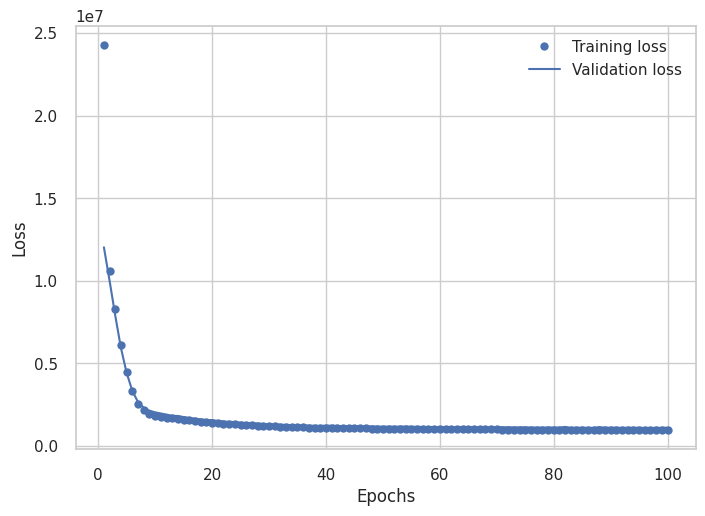

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

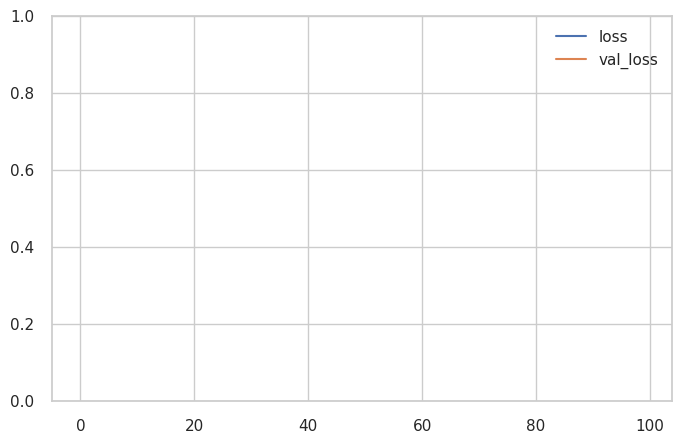

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_pred_nn = nn_model.predict(X_test, batch_size=200, verbose=0)

In [ ]:
nn_mae, nn_rmse, nn_r2 = diag_vals(nn_model)

# MAE:  553.6955463737692
# RMSE:  1052.8439980507892
# R2 score:  0.9302725498181312

337/337 [==============================] - 1s 2ms/step
MAE:  553.6955463737692
RMSE:  1052.8439980507892
R2 score:  0.9302725498181312


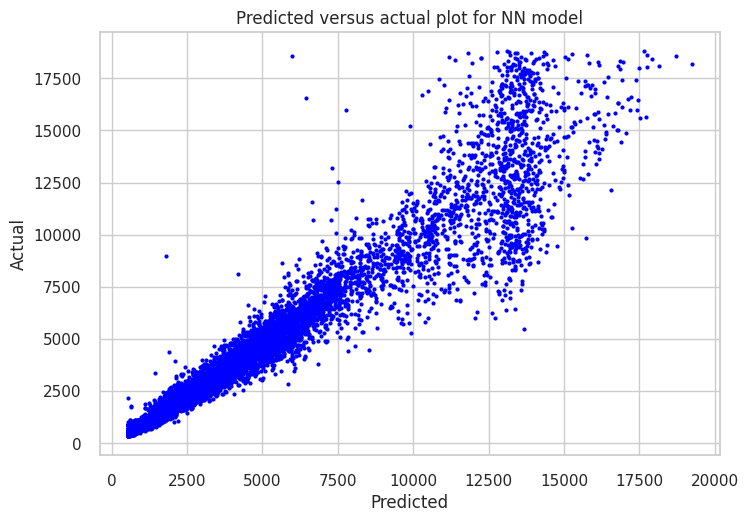

In [ ]:
plt.plot(y_pred_nn, y_test, 'o', color='blue', markersize=3)
plt.title('Predicted versus actual plot for NN model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();

In [ ]:
n_inputs = X_train.shape[1]

nn_model_tanh = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(15, activation='tanh'),
    Dense(10, activation='tanh'),
    Dense(1)
])

In [ ]:
nn_model_tanh.compile(optimizer="adam", loss="mse")

checkpoint_cb = keras.callbacks.ModelCheckpoint("tanh_keras_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

history_tanh = nn_model_tanh.fit(X_train, y_train,
                                 batch_size=25,
                                 epochs=100,
                                 verbose=2,
                                 validation_data=(X_val_nn, y_val_nn),
                                 callbacks=[checkpoint_cb, early_stopping_cb]))

nn_model_tanh = keras.models.load_model("tanh_keras_model.h5") # rollback to best model
tanh_test = nn_model_tanh.evaluate(X_test, y_test)

y_pred_tanh = nn_model_tanh.predict(X_test)

In [ ]:
pd.DataFrame(history_tanh.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
nn_mae_tanh, nn_rmse_tanh, nn_r2_tanh = diag_vals(nn_model_tanh)

#### Hyperparameter model

In [ ]:
input_shape = (X_train.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

In [ ]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2,
            overwrite=True,
            directory="my_dir",
            project_name="helloworld",)

In [ ]:
tuner_rs.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [ ]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
loss, mse = best_model.evaluate(X_test, y_test)

In [ ]:
print(loss, mse)

In [ ]:
nn_mae_hyp, nn_rmse_hyp, nn_r2_hyp = diag_vals(best_model)

#### Bayesian optimisation

In [ ]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            overwrite=True,
            directory="my_dir",
            project_name="helloworld",
        )
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

best_model_bo = tuner_bo.get_best_models(num_models=1)[0]
best_model_bo.evaluate(X_test, y_test)

In [ ]:
nn_mae_bo, nn_rmse_bo, nn_r2_bo = diag_vals(best_model_bo)

#### Hyperband

In [ ]:
tuner_hb = Hyperband(
            hypermodel,
            max_epochs=5,
            objective='mse',
            seed=42,
            executions_per_trial=2,
            overwrite=True,
            directory="my_dir",
            project_name="helloworld",
        )
tuner_hb.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
best_model_hb = tuner_hb.get_best_models(num_models=1)[0]
best_model_hb.evaluate(X_test, y_test)

In [ ]:
nn_mae_hb, nn_rmse_hb, nn_r2_hb = diag_vals(best_model_hb)

### Residuals

In [ ]:
resid_vals(y_pred_rfr)

### Results table

In [ ]:
mae_lst = [nn_mae_hb, nn_mae_bo, nn_mae_hyp, nn_mae_tanh, nn_mae, gbr_mae, abr_mae, lgb_mae, rfr_mae, xgb_mae]
rmse_lst = [nn_rmse_hb, nn_rmse_bo, nn_rmse_hyp, nn_rmse_tanh, nn_rmse, gbr_rmse, abr_rmse, lgb_rmse, rfr_rmse, xgb_rmse]
r2_lst = [nn_r2_hb, nn_r2_bo, nn_r2_hyp, nn_r2_tanh, nn_r2, gbr_r2, abr_r2, lgb_r2, rfr_r2, xgb_r2]
mod_lst = ['Hyperband model', 'Bayesian optimised model', 'Random search model', 'Tanh model', 'Baseline NN model', 'Gradient Boosting Regressor',
           'Adaboost Regressor', 'Light GBM Regressor', 'Random Forest Regressor', 'XGB Regressor']

res_df = pd.DataFrame(mod_lst, columns = ['Model'])
res_df['MAE'] = mae_lst
res_df['RMSE'] = rmse_lst
res_df['R2'] = r2_lst

NameError: ignored

### Shapley values

In [ ]:
#xgb_gridsearch.fit(X_train, y_train);

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb_hyp)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap.initjs()


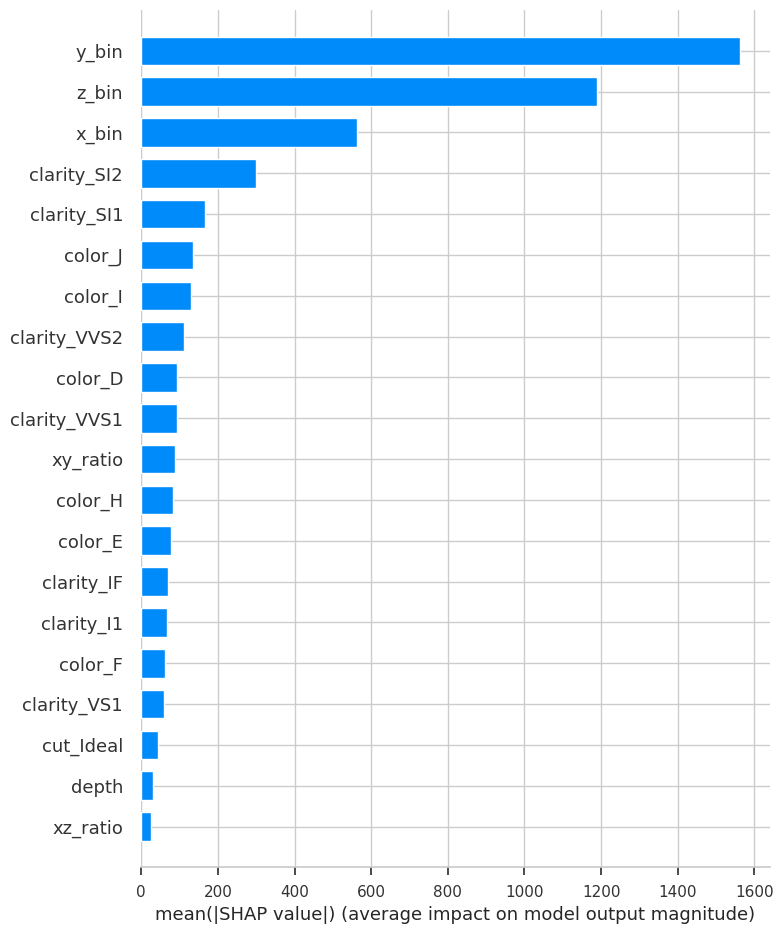

In [ ]:
shap_values = shap.TreeExplainer(xgb_hyp).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


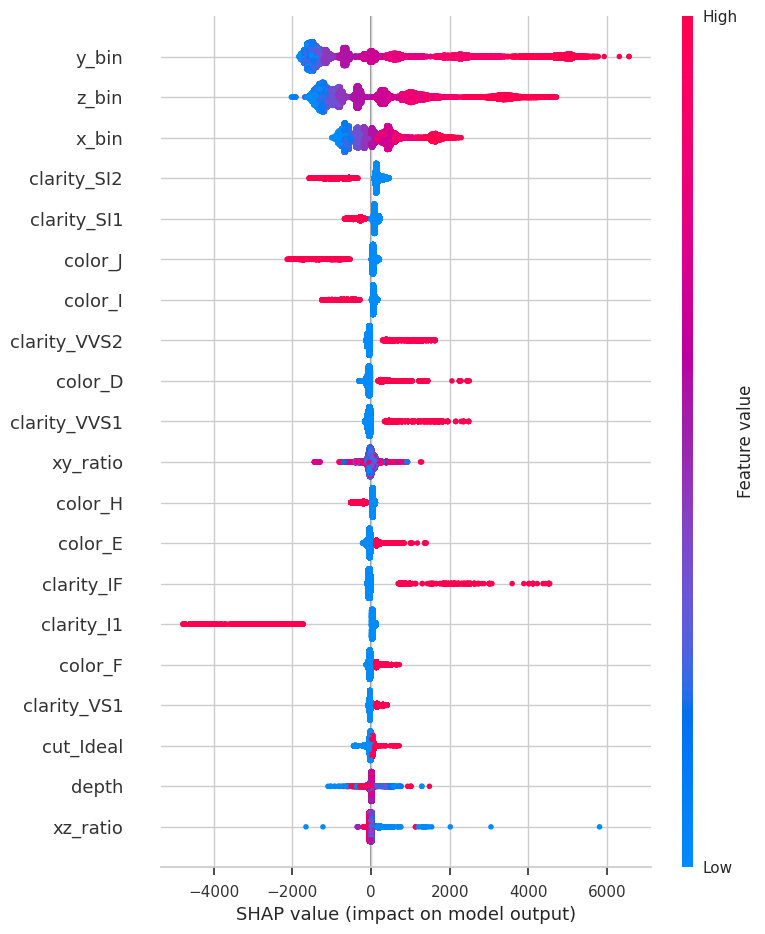

In [ ]:
shap.summary_plot(shap_values, X_train)

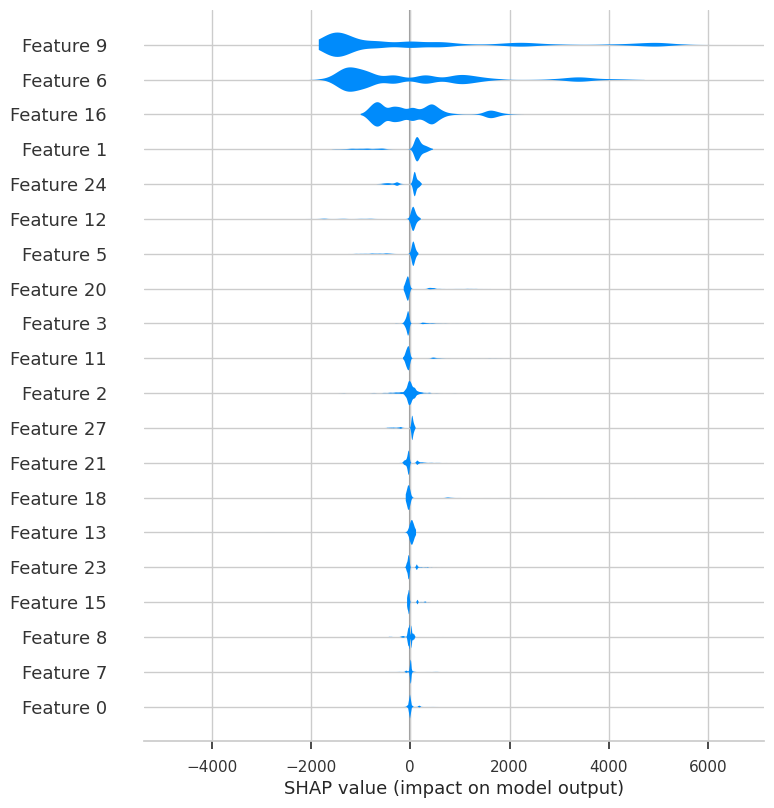

In [ ]:
shap.plots.violin(shap_values)

AttributeError: ignored

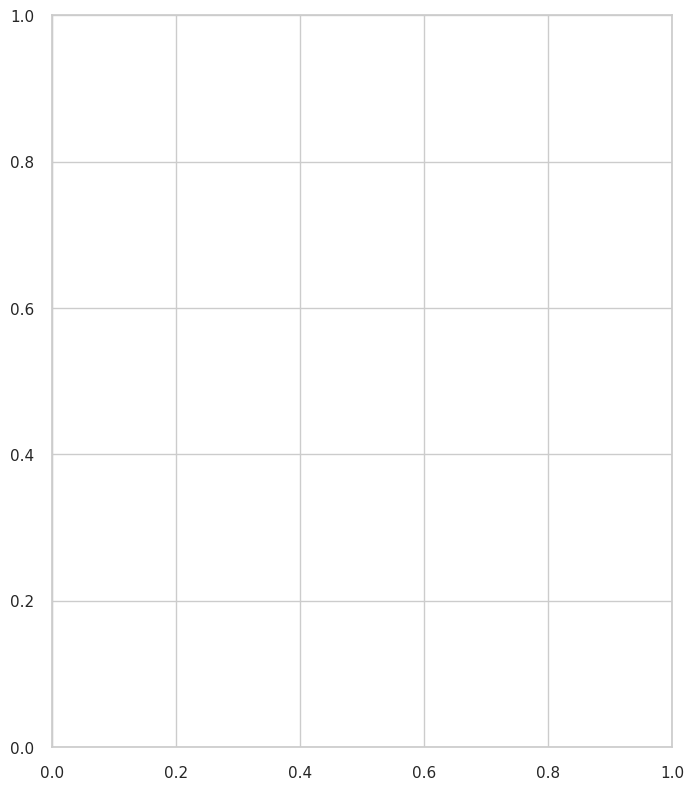

In [ ]:
shap.plots.violin(shap_values, plot_type="layered_violin")

In [ ]:
shap.plots.heatmap(shap_values)

AttributeError: ignored

In [ ]:
order = np.argsort(y_pred_hyp)
shap.plots.heatmap(shap_values, instance_order=order)

NameError: ignored

In [ ]:
order = np.argsort(data['shell weight'])
shap.plots.heatmap(shap_values, instance_order=order)

NameError: ignored